In [2]:
import os
import numpy as np
import torch
from PIL import Image

import cv2 as cv

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import random

In [3]:
badPath = "train\Bad"
badMPath = "train\BadMask"

goodPath = "train\Good"
goodMPath = "train\GoodMask"

 # Process Mask

In [4]:
badMF = os.listdir(badMPath)
goodMF = os.listdir(goodMPath)

In [5]:
bad = []
badM = []

redNL = np.array([90, 180, 180])
redNH = np.array([150, 255, 255])

for m in badMF:
    imgM = cv.imread(badMPath + "/" + m)
    
    mI = cv.inRange(cv.cvtColor(imgM, cv.COLOR_RGB2HSV), redNL, redNH)
    h, w = mI.shape
    
    mask = np.zeros((1232,1624), dtype = mI.dtype)
    mask[0:h, 0:w] = mI
    
    badM.append(mask.astype(np.bool))
    
    img = cv.imread(badPath + "/" + m.replace("_Mask", ""))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    h, w, c = img.shape
    imgP = np.zeros((1232, 1624, c), dtype=np.uint8)
    imgP[0:h, 0:w, :] = img
    
    bad.append(imgP)

In [6]:
good = []
goodM = []

blueL = np.array([90, 180, 180])
blueH = np.array([150, 255, 255])

for m in goodMF:
    imgM = cv.imread(goodMPath + "/" + m)
    imgM = cv.cvtColor(imgM, cv.COLOR_BGR2RGB)
    
    mI = cv.inRange(cv.cvtColor(imgM, cv.COLOR_RGB2HSV), redNL, redNH)
    h, w = mI.shape
    
    mask = np.zeros((1232,1624), dtype = mI.dtype)
    mask[0:h, 0:w] = mI
    
    goodM.append(mask.astype(np.bool))
    
    img = cv.imread(goodPath + "/" + m.replace("_Mask", ""))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    h, w, c = img.shape
    imgP = np.zeros((1232, 1624, c), dtype=np.uint8)
    imgP[0:h, 0:w, :] = img
    
    good.append(imgP)

In [7]:
class ImgDataset(object):
    def __init__(self, transform, goodImg, goodMask, badImg, badMask):
        self.imgs = []
        self.imgs.extend(goodImg)
        self.imgs.extend(badImg)
        
        self.masks = []
        self.masks.extend(goodMask)
        self.masks.extend(badMask)
        
        self.labs = [1] * len(goodImg)
        self.labs.extend([2] * len(badMask))
        
        
        temp = list(zip(self.imgs, self.masks, self.labs))
        random.shuffle(temp)
        self.imgs, self.masks, self.labs = zip(*temp)
        
        self.transforms = transform
        
    def __getitem__(self, ind):
        
        img = self.imgs[ind]
        
        boxes = []
        pos = np.where(self.masks[ind])
        xMin = np.min(pos[1])
        xMax = np.max(pos[1])
        yMin = np.min(pos[0])
        yMax = np.max(pos[0])
        boxes.append([xMin, yMin, xMax, yMax])
        
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        
        labels = [self.labs[ind]]
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array([self.masks[ind]]), dtype=torch.uint8)
        
        imageId = torch.tensor([ind])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        isCrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = imageId
        target["area"] = area
        target["iscrowd"] = isCrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

        
    def __len__(self):
        return len(self.imgs)

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T
'''
import importlib.util
spec1 = importlib.util.spec_from_file_location("T", "references/transforms.py")
lib1 = importlib.util.module_from_spec(spec1)
spec1.loader.exec_module(lib1)
'''

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
from engine import train_one_epoch, evaluate
'''
spec2 = importlib.util.spec_from_file_location("engine", "references/engine.py")
lib2 = importlib.util.module_from_spec(spec2)
spec2.loader.exec_module(lib2)
'''

import utils

'''
spec3 = importlib.util.spec_from_file_location("utils", "references/utils.py")
lib3 = importlib.util.module_from_spec(spec3)
spec3.loader.exec_module(lib3)
'''

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3
# use our dataset and defined transformations
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
#dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

dataset = ImgDataset(get_transform(train=True), good, goodM, bad, badM)
dataset_test = ImgDataset(get_transform(train=False), good, goodM, bad, badM)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-2:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
#model = get_model_instance_segmentation(num_classes)
model = torch.load("modelCN2.pt")

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [12]:
# let's train it for 10 epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\users\vidi\pythonenv\tensorflow2\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/483]  eta: 0:12:24  lr: 0.000015  loss: 0.1155 (0.1155)  loss_classifier: 0.0367 (0.0367)  loss_box_reg: 0.0188 (0.0188)  loss_mask: 0.0588 (0.0588)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.5417  data: 0.0818  max mem: 2131
Epoch: [0]  [ 10/483]  eta: 0:03:13  lr: 0.000119  loss: 0.1540 (0.1437)  loss_classifier: 0.0367 (0.0551)  loss_box_reg: 0.0193 (0.0224)  loss_mask: 0.0614 (0.0649)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0008 (0.0011)  time: 0.4101  data: 0.0659  max mem: 2408
Epoch: [0]  [ 20/483]  eta: 0:02:42  lr: 0.000223  loss: 0.1378 (0.1441)  loss_classifier: 0.0431 (0.0569)  loss_box_reg: 0.0193 (0.0218)  loss_mask: 0.0614 (0.0642)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 0.2908  data: 0.0576  max mem: 2408
Epoch: [0]  [ 30/483]  eta: 0:02:30  lr: 0.000326  loss: 0.1213 (0.1603)  loss_classifier: 0.0492 (0.0569)  loss_box_reg: 0.0183 (0.0238)  loss_mask: 0.0569 (0.0780) 

Epoch: [0]  [300/483]  eta: 0:00:54  lr: 0.003124  loss: 0.0971 (0.1282)  loss_classifier: 0.0289 (0.0414)  loss_box_reg: 0.0159 (0.0227)  loss_mask: 0.0495 (0.0629)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0008)  time: 0.2946  data: 0.0613  max mem: 2409
Epoch: [0]  [310/483]  eta: 0:00:51  lr: 0.003228  loss: 0.1066 (0.1283)  loss_classifier: 0.0393 (0.0415)  loss_box_reg: 0.0173 (0.0228)  loss_mask: 0.0517 (0.0629)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0005 (0.0008)  time: 0.2883  data: 0.0549  max mem: 2409
Epoch: [0]  [320/483]  eta: 0:00:48  lr: 0.003332  loss: 0.1065 (0.1278)  loss_classifier: 0.0318 (0.0411)  loss_box_reg: 0.0201 (0.0229)  loss_mask: 0.0515 (0.0627)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0005 (0.0008)  time: 0.2883  data: 0.0551  max mem: 2409
Epoch: [0]  [330/483]  eta: 0:00:45  lr: 0.003435  loss: 0.0983 (0.1275)  loss_classifier: 0.0253 (0.0406)  loss_box_reg: 0.0209 (0.0231)  loss_mask: 0.0496 (0.0626) 

Epoch: [1]  [ 10/483]  eta: 0:02:19  lr: 0.005000  loss: 0.0882 (0.0949)  loss_classifier: 0.0236 (0.0302)  loss_box_reg: 0.0161 (0.0164)  loss_mask: 0.0471 (0.0478)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2957  data: 0.0627  max mem: 2409
Epoch: [1]  [ 20/483]  eta: 0:02:15  lr: 0.005000  loss: 0.0882 (0.0956)  loss_classifier: 0.0232 (0.0291)  loss_box_reg: 0.0161 (0.0163)  loss_mask: 0.0474 (0.0495)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.2925  data: 0.0599  max mem: 2409
Epoch: [1]  [ 30/483]  eta: 0:02:13  lr: 0.005000  loss: 0.0885 (0.0939)  loss_classifier: 0.0225 (0.0274)  loss_box_reg: 0.0156 (0.0162)  loss_mask: 0.0492 (0.0495)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.2944  data: 0.0619  max mem: 2409
Epoch: [1]  [ 40/483]  eta: 0:02:10  lr: 0.005000  loss: 0.0893 (0.0952)  loss_classifier: 0.0215 (0.0284)  loss_box_reg: 0.0162 (0.0171)  loss_mask: 0.0487 (0.0491) 

Epoch: [1]  [310/483]  eta: 0:00:50  lr: 0.005000  loss: 0.1052 (0.1064)  loss_classifier: 0.0283 (0.0282)  loss_box_reg: 0.0238 (0.0221)  loss_mask: 0.0497 (0.0553)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.2908  data: 0.0570  max mem: 2409
Epoch: [1]  [320/483]  eta: 0:00:47  lr: 0.005000  loss: 0.0974 (0.1066)  loss_classifier: 0.0247 (0.0283)  loss_box_reg: 0.0191 (0.0221)  loss_mask: 0.0495 (0.0553)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.2937  data: 0.0596  max mem: 2409
Epoch: [1]  [330/483]  eta: 0:00:44  lr: 0.005000  loss: 0.0858 (0.1063)  loss_classifier: 0.0239 (0.0285)  loss_box_reg: 0.0147 (0.0220)  loss_mask: 0.0491 (0.0551)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.2905  data: 0.0568  max mem: 2409
Epoch: [1]  [340/483]  eta: 0:00:41  lr: 0.005000  loss: 0.0842 (0.1060)  loss_classifier: 0.0191 (0.0284)  loss_box_reg: 0.0170 (0.0218)  loss_mask: 0.0472 (0.0549) 

Epoch: [2]  [ 20/483]  eta: 0:02:14  lr: 0.005000  loss: 0.0837 (0.0891)  loss_classifier: 0.0156 (0.0188)  loss_box_reg: 0.0147 (0.0167)  loss_mask: 0.0482 (0.0524)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.2914  data: 0.0584  max mem: 2409
Epoch: [2]  [ 30/483]  eta: 0:02:12  lr: 0.005000  loss: 0.0800 (0.0943)  loss_classifier: 0.0143 (0.0218)  loss_box_reg: 0.0152 (0.0182)  loss_mask: 0.0485 (0.0531)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2924  data: 0.0593  max mem: 2409
Epoch: [2]  [ 40/483]  eta: 0:02:09  lr: 0.005000  loss: 0.0786 (0.0919)  loss_classifier: 0.0131 (0.0213)  loss_box_reg: 0.0173 (0.0177)  loss_mask: 0.0483 (0.0518)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0004 (0.0006)  time: 0.2911  data: 0.0579  max mem: 2409
Epoch: [2]  [ 50/483]  eta: 0:02:06  lr: 0.005000  loss: 0.0788 (0.0918)  loss_classifier: 0.0154 (0.0205)  loss_box_reg: 0.0170 (0.0185)  loss_mask: 0.0462 (0.0518) 

Epoch: [2]  [320/483]  eta: 0:00:47  lr: 0.005000  loss: 0.0813 (0.0977)  loss_classifier: 0.0171 (0.0237)  loss_box_reg: 0.0146 (0.0201)  loss_mask: 0.0466 (0.0530)  loss_objectness: 0.0000 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.2899  data: 0.0560  max mem: 2409
Epoch: [2]  [330/483]  eta: 0:00:44  lr: 0.005000  loss: 0.0840 (0.0977)  loss_classifier: 0.0178 (0.0237)  loss_box_reg: 0.0138 (0.0201)  loss_mask: 0.0482 (0.0531)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.2896  data: 0.0553  max mem: 2409
Epoch: [2]  [340/483]  eta: 0:00:41  lr: 0.005000  loss: 0.0807 (0.0972)  loss_classifier: 0.0147 (0.0234)  loss_box_reg: 0.0135 (0.0200)  loss_mask: 0.0490 (0.0530)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.2892  data: 0.0551  max mem: 2409
Epoch: [2]  [350/483]  eta: 0:00:38  lr: 0.005000  loss: 0.0794 (0.0967)  loss_classifier: 0.0137 (0.0233)  loss_box_reg: 0.0133 (0.0198)  loss_mask: 0.0466 (0.0528) 

Epoch: [3]  [ 30/483]  eta: 0:02:11  lr: 0.000500  loss: 0.0718 (0.0858)  loss_classifier: 0.0106 (0.0193)  loss_box_reg: 0.0122 (0.0153)  loss_mask: 0.0474 (0.0507)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0560  max mem: 2409
Epoch: [3]  [ 40/483]  eta: 0:02:08  lr: 0.000500  loss: 0.0753 (0.0830)  loss_classifier: 0.0152 (0.0185)  loss_box_reg: 0.0115 (0.0143)  loss_mask: 0.0473 (0.0496)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2893  data: 0.0555  max mem: 2409
Epoch: [3]  [ 50/483]  eta: 0:02:05  lr: 0.000500  loss: 0.0693 (0.0805)  loss_classifier: 0.0105 (0.0174)  loss_box_reg: 0.0092 (0.0133)  loss_mask: 0.0471 (0.0491)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2879  data: 0.0544  max mem: 2409
Epoch: [3]  [ 60/483]  eta: 0:02:02  lr: 0.000500  loss: 0.0660 (0.0788)  loss_classifier: 0.0090 (0.0172)  loss_box_reg: 0.0074 (0.0124)  loss_mask: 0.0467 (0.0486) 

Epoch: [3]  [330/483]  eta: 0:00:44  lr: 0.000500  loss: 0.0650 (0.0773)  loss_classifier: 0.0090 (0.0160)  loss_box_reg: 0.0070 (0.0114)  loss_mask: 0.0461 (0.0494)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2924  data: 0.0588  max mem: 2409
Epoch: [3]  [340/483]  eta: 0:00:41  lr: 0.000500  loss: 0.0640 (0.0774)  loss_classifier: 0.0090 (0.0159)  loss_box_reg: 0.0075 (0.0115)  loss_mask: 0.0463 (0.0494)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2903  data: 0.0558  max mem: 2409
Epoch: [3]  [350/483]  eta: 0:00:38  lr: 0.000500  loss: 0.0642 (0.0776)  loss_classifier: 0.0086 (0.0158)  loss_box_reg: 0.0091 (0.0116)  loss_mask: 0.0466 (0.0496)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2913  data: 0.0571  max mem: 2409
Epoch: [3]  [360/483]  eta: 0:00:35  lr: 0.000500  loss: 0.0680 (0.0779)  loss_classifier: 0.0106 (0.0158)  loss_box_reg: 0.0096 (0.0118)  loss_mask: 0.0457 (0.0497) 

Epoch: [4]  [ 40/483]  eta: 0:02:07  lr: 0.000500  loss: 0.0685 (0.0784)  loss_classifier: 0.0100 (0.0130)  loss_box_reg: 0.0087 (0.0134)  loss_mask: 0.0468 (0.0516)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2893  data: 0.0552  max mem: 2409
Epoch: [4]  [ 50/483]  eta: 0:02:04  lr: 0.000500  loss: 0.0660 (0.0755)  loss_classifier: 0.0101 (0.0125)  loss_box_reg: 0.0071 (0.0121)  loss_mask: 0.0465 (0.0506)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2849  data: 0.0512  max mem: 2409
Epoch: [4]  [ 60/483]  eta: 0:02:01  lr: 0.000500  loss: 0.0654 (0.0764)  loss_classifier: 0.0089 (0.0132)  loss_box_reg: 0.0075 (0.0120)  loss_mask: 0.0459 (0.0507)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2855  data: 0.0526  max mem: 2409
Epoch: [4]  [ 70/483]  eta: 0:01:58  lr: 0.000500  loss: 0.0652 (0.0754)  loss_classifier: 0.0084 (0.0134)  loss_box_reg: 0.0081 (0.0115)  loss_mask: 0.0462 (0.0501) 

Epoch: [4]  [340/483]  eta: 0:00:41  lr: 0.000500  loss: 0.0689 (0.0761)  loss_classifier: 0.0113 (0.0143)  loss_box_reg: 0.0086 (0.0116)  loss_mask: 0.0457 (0.0497)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2960  data: 0.0617  max mem: 2409
Epoch: [4]  [350/483]  eta: 0:00:38  lr: 0.000500  loss: 0.0667 (0.0764)  loss_classifier: 0.0108 (0.0144)  loss_box_reg: 0.0088 (0.0116)  loss_mask: 0.0465 (0.0499)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2916  data: 0.0578  max mem: 2409
Epoch: [4]  [360/483]  eta: 0:00:35  lr: 0.000500  loss: 0.0667 (0.0767)  loss_classifier: 0.0101 (0.0146)  loss_box_reg: 0.0097 (0.0117)  loss_mask: 0.0465 (0.0500)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2891  data: 0.0559  max mem: 2409
Epoch: [4]  [370/483]  eta: 0:00:32  lr: 0.000500  loss: 0.0653 (0.0766)  loss_classifier: 0.0098 (0.0146)  loss_box_reg: 0.0080 (0.0116)  loss_mask: 0.0464 (0.0499) 

Epoch: [5]  [ 50/483]  eta: 0:02:04  lr: 0.000500  loss: 0.0629 (0.0768)  loss_classifier: 0.0073 (0.0152)  loss_box_reg: 0.0078 (0.0117)  loss_mask: 0.0459 (0.0496)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2864  data: 0.0531  max mem: 2409
Epoch: [5]  [ 60/483]  eta: 0:02:01  lr: 0.000500  loss: 0.0643 (0.0763)  loss_classifier: 0.0098 (0.0145)  loss_box_reg: 0.0083 (0.0115)  loss_mask: 0.0463 (0.0499)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2882  data: 0.0542  max mem: 2409
Epoch: [5]  [ 70/483]  eta: 0:01:59  lr: 0.000500  loss: 0.0647 (0.0754)  loss_classifier: 0.0100 (0.0143)  loss_box_reg: 0.0083 (0.0112)  loss_mask: 0.0464 (0.0495)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2886  data: 0.0546  max mem: 2409
Epoch: [5]  [ 80/483]  eta: 0:01:56  lr: 0.000500  loss: 0.0658 (0.0760)  loss_classifier: 0.0097 (0.0143)  loss_box_reg: 0.0109 (0.0115)  loss_mask: 0.0475 (0.0498) 

Epoch: [5]  [350/483]  eta: 0:00:38  lr: 0.000500  loss: 0.0683 (0.0739)  loss_classifier: 0.0106 (0.0132)  loss_box_reg: 0.0073 (0.0110)  loss_mask: 0.0464 (0.0492)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2885  data: 0.0541  max mem: 2409
Epoch: [5]  [360/483]  eta: 0:00:35  lr: 0.000500  loss: 0.0665 (0.0747)  loss_classifier: 0.0118 (0.0134)  loss_box_reg: 0.0078 (0.0113)  loss_mask: 0.0458 (0.0495)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2887  data: 0.0538  max mem: 2409
Epoch: [5]  [370/483]  eta: 0:00:32  lr: 0.000500  loss: 0.0665 (0.0747)  loss_classifier: 0.0120 (0.0134)  loss_box_reg: 0.0081 (0.0113)  loss_mask: 0.0463 (0.0495)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.2917  data: 0.0570  max mem: 2409
Epoch: [5]  [380/483]  eta: 0:00:29  lr: 0.000500  loss: 0.0643 (0.0746)  loss_classifier: 0.0090 (0.0133)  loss_box_reg: 0.0083 (0.0113)  loss_mask: 0.0464 (0.0495) 

Epoch: [6]  [ 60/483]  eta: 0:02:02  lr: 0.000050  loss: 0.0631 (0.0673)  loss_classifier: 0.0089 (0.0103)  loss_box_reg: 0.0080 (0.0090)  loss_mask: 0.0455 (0.0477)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2915  data: 0.0579  max mem: 2409
Epoch: [6]  [ 70/483]  eta: 0:01:59  lr: 0.000050  loss: 0.0614 (0.0674)  loss_classifier: 0.0080 (0.0106)  loss_box_reg: 0.0079 (0.0089)  loss_mask: 0.0457 (0.0475)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2934  data: 0.0591  max mem: 2409
Epoch: [6]  [ 80/483]  eta: 0:01:56  lr: 0.000050  loss: 0.0646 (0.0671)  loss_classifier: 0.0085 (0.0106)  loss_box_reg: 0.0075 (0.0088)  loss_mask: 0.0459 (0.0473)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2893  data: 0.0550  max mem: 2409
Epoch: [6]  [ 90/483]  eta: 0:01:53  lr: 0.000050  loss: 0.0648 (0.0668)  loss_classifier: 0.0092 (0.0109)  loss_box_reg: 0.0074 (0.0087)  loss_mask: 0.0453 (0.0469) 

Epoch: [6]  [360/483]  eta: 0:00:35  lr: 0.000050  loss: 0.0622 (0.0711)  loss_classifier: 0.0083 (0.0118)  loss_box_reg: 0.0075 (0.0101)  loss_mask: 0.0458 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2880  data: 0.0538  max mem: 2409
Epoch: [6]  [370/483]  eta: 0:00:32  lr: 0.000050  loss: 0.0628 (0.0713)  loss_classifier: 0.0078 (0.0118)  loss_box_reg: 0.0092 (0.0102)  loss_mask: 0.0476 (0.0489)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2888  data: 0.0543  max mem: 2409
Epoch: [6]  [380/483]  eta: 0:00:29  lr: 0.000050  loss: 0.0654 (0.0717)  loss_classifier: 0.0082 (0.0119)  loss_box_reg: 0.0100 (0.0103)  loss_mask: 0.0484 (0.0490)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2855  data: 0.0511  max mem: 2409
Epoch: [6]  [390/483]  eta: 0:00:26  lr: 0.000050  loss: 0.0667 (0.0717)  loss_classifier: 0.0089 (0.0119)  loss_box_reg: 0.0090 (0.0103)  loss_mask: 0.0480 (0.0490) 

Epoch: [7]  [ 70/483]  eta: 0:02:00  lr: 0.000050  loss: 0.0604 (0.0696)  loss_classifier: 0.0089 (0.0110)  loss_box_reg: 0.0070 (0.0098)  loss_mask: 0.0462 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2911  data: 0.0570  max mem: 2409
Epoch: [7]  [ 80/483]  eta: 0:01:57  lr: 0.000050  loss: 0.0616 (0.0694)  loss_classifier: 0.0089 (0.0110)  loss_box_reg: 0.0081 (0.0097)  loss_mask: 0.0458 (0.0482)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2957  data: 0.0608  max mem: 2409
Epoch: [7]  [ 90/483]  eta: 0:01:54  lr: 0.000050  loss: 0.0628 (0.0687)  loss_classifier: 0.0074 (0.0109)  loss_box_reg: 0.0069 (0.0093)  loss_mask: 0.0458 (0.0480)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2989  data: 0.0638  max mem: 2409
Epoch: [7]  [100/483]  eta: 0:01:51  lr: 0.000050  loss: 0.0621 (0.0681)  loss_classifier: 0.0074 (0.0106)  loss_box_reg: 0.0071 (0.0093)  loss_mask: 0.0450 (0.0478) 

Epoch: [7]  [370/483]  eta: 0:00:32  lr: 0.000050  loss: 0.0584 (0.0712)  loss_classifier: 0.0079 (0.0123)  loss_box_reg: 0.0071 (0.0099)  loss_mask: 0.0448 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2977  data: 0.0643  max mem: 2409
Epoch: [7]  [380/483]  eta: 0:00:29  lr: 0.000050  loss: 0.0637 (0.0713)  loss_classifier: 0.0085 (0.0123)  loss_box_reg: 0.0077 (0.0100)  loss_mask: 0.0451 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2981  data: 0.0640  max mem: 2409
Epoch: [7]  [390/483]  eta: 0:00:26  lr: 0.000050  loss: 0.0646 (0.0713)  loss_classifier: 0.0079 (0.0122)  loss_box_reg: 0.0092 (0.0101)  loss_mask: 0.0459 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2946  data: 0.0604  max mem: 2409
Epoch: [7]  [400/483]  eta: 0:00:24  lr: 0.000050  loss: 0.0609 (0.0712)  loss_classifier: 0.0079 (0.0121)  loss_box_reg: 0.0086 (0.0101)  loss_mask: 0.0456 (0.0485) 

Epoch: [8]  [ 80/483]  eta: 0:01:57  lr: 0.000050  loss: 0.0626 (0.0703)  loss_classifier: 0.0098 (0.0119)  loss_box_reg: 0.0067 (0.0096)  loss_mask: 0.0456 (0.0482)  loss_objectness: 0.0000 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2877  data: 0.0551  max mem: 2409
Epoch: [8]  [ 90/483]  eta: 0:01:53  lr: 0.000050  loss: 0.0624 (0.0701)  loss_classifier: 0.0098 (0.0116)  loss_box_reg: 0.0074 (0.0096)  loss_mask: 0.0449 (0.0482)  loss_objectness: 0.0000 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2871  data: 0.0542  max mem: 2409
Epoch: [8]  [100/483]  eta: 0:01:51  lr: 0.000050  loss: 0.0592 (0.0692)  loss_classifier: 0.0063 (0.0113)  loss_box_reg: 0.0074 (0.0094)  loss_mask: 0.0449 (0.0479)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2927  data: 0.0585  max mem: 2409
Epoch: [8]  [110/483]  eta: 0:01:48  lr: 0.000050  loss: 0.0633 (0.0701)  loss_classifier: 0.0092 (0.0116)  loss_box_reg: 0.0087 (0.0096)  loss_mask: 0.0469 (0.0484) 

Epoch: [8]  [380/483]  eta: 0:00:29  lr: 0.000050  loss: 0.0608 (0.0713)  loss_classifier: 0.0077 (0.0121)  loss_box_reg: 0.0070 (0.0101)  loss_mask: 0.0454 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2940  data: 0.0600  max mem: 2409
Epoch: [8]  [390/483]  eta: 0:00:27  lr: 0.000050  loss: 0.0638 (0.0713)  loss_classifier: 0.0090 (0.0121)  loss_box_reg: 0.0082 (0.0101)  loss_mask: 0.0455 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2883  data: 0.0546  max mem: 2409
Epoch: [8]  [400/483]  eta: 0:00:24  lr: 0.000050  loss: 0.0651 (0.0715)  loss_classifier: 0.0095 (0.0123)  loss_box_reg: 0.0090 (0.0100)  loss_mask: 0.0466 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2942  data: 0.0606  max mem: 2409
Epoch: [8]  [410/483]  eta: 0:00:21  lr: 0.000050  loss: 0.0651 (0.0714)  loss_classifier: 0.0091 (0.0122)  loss_box_reg: 0.0080 (0.0100)  loss_mask: 0.0466 (0.0486) 

Epoch: [9]  [ 90/483]  eta: 0:01:54  lr: 0.000005  loss: 0.0620 (0.0732)  loss_classifier: 0.0104 (0.0136)  loss_box_reg: 0.0070 (0.0102)  loss_mask: 0.0451 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.2875  data: 0.0542  max mem: 2409
Epoch: [9]  [100/483]  eta: 0:01:51  lr: 0.000005  loss: 0.0632 (0.0734)  loss_classifier: 0.0079 (0.0136)  loss_box_reg: 0.0080 (0.0104)  loss_mask: 0.0452 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.2899  data: 0.0561  max mem: 2409
Epoch: [9]  [110/483]  eta: 0:01:48  lr: 0.000005  loss: 0.0614 (0.0731)  loss_classifier: 0.0076 (0.0135)  loss_box_reg: 0.0076 (0.0102)  loss_mask: 0.0460 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2929  data: 0.0588  max mem: 2409
Epoch: [9]  [120/483]  eta: 0:01:45  lr: 0.000005  loss: 0.0613 (0.0723)  loss_classifier: 0.0076 (0.0130)  loss_box_reg: 0.0067 (0.0101)  loss_mask: 0.0468 (0.0486) 

Epoch: [9]  [390/483]  eta: 0:00:27  lr: 0.000005  loss: 0.0625 (0.0715)  loss_classifier: 0.0080 (0.0124)  loss_box_reg: 0.0067 (0.0101)  loss_mask: 0.0452 (0.0485)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2935  data: 0.0597  max mem: 2409
Epoch: [9]  [400/483]  eta: 0:00:24  lr: 0.000005  loss: 0.0612 (0.0713)  loss_classifier: 0.0077 (0.0123)  loss_box_reg: 0.0075 (0.0100)  loss_mask: 0.0461 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2931  data: 0.0589  max mem: 2409
Epoch: [9]  [410/483]  eta: 0:00:21  lr: 0.000005  loss: 0.0602 (0.0712)  loss_classifier: 0.0079 (0.0122)  loss_box_reg: 0.0076 (0.0100)  loss_mask: 0.0458 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2896  data: 0.0551  max mem: 2409
Epoch: [9]  [420/483]  eta: 0:00:18  lr: 0.000005  loss: 0.0632 (0.0711)  loss_classifier: 0.0093 (0.0123)  loss_box_reg: 0.0071 (0.0099)  loss_mask: 0.0452 (0.0484) 

Epoch: [10]  [100/483]  eta: 0:01:50  lr: 0.000005  loss: 0.0632 (0.0708)  loss_classifier: 0.0081 (0.0118)  loss_box_reg: 0.0079 (0.0098)  loss_mask: 0.0462 (0.0489)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2897  data: 0.0558  max mem: 2409
Epoch: [10]  [110/483]  eta: 0:01:48  lr: 0.000005  loss: 0.0596 (0.0702)  loss_classifier: 0.0066 (0.0115)  loss_box_reg: 0.0074 (0.0097)  loss_mask: 0.0458 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2940  data: 0.0597  max mem: 2409
Epoch: [10]  [120/483]  eta: 0:01:45  lr: 0.000005  loss: 0.0596 (0.0698)  loss_classifier: 0.0074 (0.0114)  loss_box_reg: 0.0083 (0.0098)  loss_mask: 0.0450 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2957  data: 0.0618  max mem: 2409
Epoch: [10]  [130/483]  eta: 0:01:42  lr: 0.000005  loss: 0.0654 (0.0706)  loss_classifier: 0.0081 (0.0114)  loss_box_reg: 0.0095 (0.0102)  loss_mask: 0.0460 (0.04

Epoch: [10]  [400/483]  eta: 0:00:24  lr: 0.000005  loss: 0.0615 (0.0716)  loss_classifier: 0.0096 (0.0119)  loss_box_reg: 0.0093 (0.0103)  loss_mask: 0.0458 (0.0489)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2868  data: 0.0532  max mem: 2409
Epoch: [10]  [410/483]  eta: 0:00:21  lr: 0.000005  loss: 0.0613 (0.0716)  loss_classifier: 0.0089 (0.0120)  loss_box_reg: 0.0081 (0.0103)  loss_mask: 0.0451 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2949  data: 0.0612  max mem: 2409
Epoch: [10]  [420/483]  eta: 0:00:18  lr: 0.000005  loss: 0.0617 (0.0715)  loss_classifier: 0.0077 (0.0120)  loss_box_reg: 0.0077 (0.0103)  loss_mask: 0.0451 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2986  data: 0.0645  max mem: 2409
Epoch: [10]  [430/483]  eta: 0:00:15  lr: 0.000005  loss: 0.0639 (0.0713)  loss_classifier: 0.0077 (0.0119)  loss_box_reg: 0.0077 (0.0102)  loss_mask: 0.0457 (0.04

Epoch: [11]  [110/483]  eta: 0:01:48  lr: 0.000005  loss: 0.0640 (0.0720)  loss_classifier: 0.0086 (0.0113)  loss_box_reg: 0.0073 (0.0102)  loss_mask: 0.0467 (0.0501)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2919  data: 0.0580  max mem: 2409
Epoch: [11]  [120/483]  eta: 0:01:46  lr: 0.000005  loss: 0.0612 (0.0719)  loss_classifier: 0.0086 (0.0111)  loss_box_reg: 0.0065 (0.0102)  loss_mask: 0.0462 (0.0502)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2916  data: 0.0575  max mem: 2409
Epoch: [11]  [130/483]  eta: 0:01:42  lr: 0.000005  loss: 0.0614 (0.0710)  loss_classifier: 0.0089 (0.0110)  loss_box_reg: 0.0065 (0.0099)  loss_mask: 0.0445 (0.0497)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2887  data: 0.0546  max mem: 2409
Epoch: [11]  [140/483]  eta: 0:01:40  lr: 0.000005  loss: 0.0638 (0.0714)  loss_classifier: 0.0101 (0.0110)  loss_box_reg: 0.0075 (0.0102)  loss_mask: 0.0445 (0.04

Epoch: [11]  [410/483]  eta: 0:00:21  lr: 0.000005  loss: 0.0611 (0.0705)  loss_classifier: 0.0078 (0.0118)  loss_box_reg: 0.0085 (0.0099)  loss_mask: 0.0454 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2857  data: 0.0517  max mem: 2409
Epoch: [11]  [420/483]  eta: 0:00:18  lr: 0.000005  loss: 0.0604 (0.0706)  loss_classifier: 0.0077 (0.0119)  loss_box_reg: 0.0066 (0.0098)  loss_mask: 0.0456 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2898  data: 0.0558  max mem: 2409
Epoch: [11]  [430/483]  eta: 0:00:15  lr: 0.000005  loss: 0.0633 (0.0706)  loss_classifier: 0.0092 (0.0119)  loss_box_reg: 0.0081 (0.0099)  loss_mask: 0.0459 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2927  data: 0.0586  max mem: 2409
Epoch: [11]  [440/483]  eta: 0:00:12  lr: 0.000005  loss: 0.0637 (0.0706)  loss_classifier: 0.0092 (0.0119)  loss_box_reg: 0.0086 (0.0099)  loss_mask: 0.0462 (0.04

Epoch: [12]  [120/483]  eta: 0:01:45  lr: 0.000001  loss: 0.0620 (0.0726)  loss_classifier: 0.0092 (0.0131)  loss_box_reg: 0.0078 (0.0103)  loss_mask: 0.0447 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2918  data: 0.0583  max mem: 2409
Epoch: [12]  [130/483]  eta: 0:01:42  lr: 0.000001  loss: 0.0616 (0.0726)  loss_classifier: 0.0092 (0.0131)  loss_box_reg: 0.0070 (0.0103)  loss_mask: 0.0450 (0.0487)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2924  data: 0.0589  max mem: 2409
Epoch: [12]  [140/483]  eta: 0:01:39  lr: 0.000001  loss: 0.0622 (0.0733)  loss_classifier: 0.0082 (0.0130)  loss_box_reg: 0.0075 (0.0108)  loss_mask: 0.0463 (0.0490)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2908  data: 0.0573  max mem: 2409
Epoch: [12]  [150/483]  eta: 0:01:36  lr: 0.000001  loss: 0.0637 (0.0728)  loss_classifier: 0.0079 (0.0127)  loss_box_reg: 0.0070 (0.0106)  loss_mask: 0.0459 (0.04

Epoch: [12]  [420/483]  eta: 0:00:18  lr: 0.000001  loss: 0.0576 (0.0707)  loss_classifier: 0.0056 (0.0118)  loss_box_reg: 0.0064 (0.0101)  loss_mask: 0.0453 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2926  data: 0.0592  max mem: 2409
Epoch: [12]  [430/483]  eta: 0:00:15  lr: 0.000001  loss: 0.0616 (0.0706)  loss_classifier: 0.0067 (0.0117)  loss_box_reg: 0.0067 (0.0100)  loss_mask: 0.0468 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2921  data: 0.0581  max mem: 2409
Epoch: [12]  [440/483]  eta: 0:00:12  lr: 0.000001  loss: 0.0612 (0.0703)  loss_classifier: 0.0077 (0.0117)  loss_box_reg: 0.0061 (0.0099)  loss_mask: 0.0457 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2880  data: 0.0539  max mem: 2409
Epoch: [12]  [450/483]  eta: 0:00:09  lr: 0.000001  loss: 0.0619 (0.0705)  loss_classifier: 0.0086 (0.0117)  loss_box_reg: 0.0067 (0.0100)  loss_mask: 0.0453 (0.04

Epoch: [13]  [130/483]  eta: 0:01:42  lr: 0.000001  loss: 0.0634 (0.0699)  loss_classifier: 0.0090 (0.0116)  loss_box_reg: 0.0079 (0.0096)  loss_mask: 0.0460 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2857  data: 0.0516  max mem: 2409
Epoch: [13]  [140/483]  eta: 0:01:39  lr: 0.000001  loss: 0.0634 (0.0695)  loss_classifier: 0.0083 (0.0113)  loss_box_reg: 0.0073 (0.0095)  loss_mask: 0.0463 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2866  data: 0.0537  max mem: 2409
Epoch: [13]  [150/483]  eta: 0:01:36  lr: 0.000001  loss: 0.0607 (0.0695)  loss_classifier: 0.0081 (0.0112)  loss_box_reg: 0.0064 (0.0095)  loss_mask: 0.0455 (0.0483)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2889  data: 0.0564  max mem: 2409
Epoch: [13]  [160/483]  eta: 0:01:33  lr: 0.000001  loss: 0.0632 (0.0696)  loss_classifier: 0.0085 (0.0114)  loss_box_reg: 0.0068 (0.0095)  loss_mask: 0.0456 (0.04

Epoch: [13]  [430/483]  eta: 0:00:15  lr: 0.000001  loss: 0.0599 (0.0713)  loss_classifier: 0.0089 (0.0120)  loss_box_reg: 0.0064 (0.0103)  loss_mask: 0.0445 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2885  data: 0.0540  max mem: 2409
Epoch: [13]  [440/483]  eta: 0:00:12  lr: 0.000001  loss: 0.0635 (0.0714)  loss_classifier: 0.0078 (0.0121)  loss_box_reg: 0.0085 (0.0102)  loss_mask: 0.0449 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2937  data: 0.0589  max mem: 2409
Epoch: [13]  [450/483]  eta: 0:00:09  lr: 0.000001  loss: 0.0635 (0.0712)  loss_classifier: 0.0080 (0.0121)  loss_box_reg: 0.0086 (0.0102)  loss_mask: 0.0458 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2925  data: 0.0585  max mem: 2409
Epoch: [13]  [460/483]  eta: 0:00:06  lr: 0.000001  loss: 0.0612 (0.0711)  loss_classifier: 0.0087 (0.0120)  loss_box_reg: 0.0060 (0.0101)  loss_mask: 0.0458 (0.04

Epoch: [14]  [140/483]  eta: 0:01:39  lr: 0.000001  loss: 0.0627 (0.0695)  loss_classifier: 0.0069 (0.0117)  loss_box_reg: 0.0076 (0.0097)  loss_mask: 0.0464 (0.0476)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2916  data: 0.0568  max mem: 2409
Epoch: [14]  [150/483]  eta: 0:01:36  lr: 0.000001  loss: 0.0617 (0.0690)  loss_classifier: 0.0065 (0.0116)  loss_box_reg: 0.0079 (0.0096)  loss_mask: 0.0455 (0.0474)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2871  data: 0.0534  max mem: 2409
Epoch: [14]  [160/483]  eta: 0:01:33  lr: 0.000001  loss: 0.0622 (0.0704)  loss_classifier: 0.0081 (0.0118)  loss_box_reg: 0.0079 (0.0100)  loss_mask: 0.0466 (0.0481)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2880  data: 0.0548  max mem: 2409
Epoch: [14]  [170/483]  eta: 0:01:30  lr: 0.000001  loss: 0.0619 (0.0703)  loss_classifier: 0.0093 (0.0119)  loss_box_reg: 0.0060 (0.0100)  loss_mask: 0.0465 (0.04

Epoch: [14]  [440/483]  eta: 0:00:12  lr: 0.000001  loss: 0.0636 (0.0710)  loss_classifier: 0.0075 (0.0117)  loss_box_reg: 0.0090 (0.0100)  loss_mask: 0.0464 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2909  data: 0.0562  max mem: 2409
Epoch: [14]  [450/483]  eta: 0:00:09  lr: 0.000001  loss: 0.0643 (0.0709)  loss_classifier: 0.0097 (0.0117)  loss_box_reg: 0.0084 (0.0100)  loss_mask: 0.0460 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2933  data: 0.0591  max mem: 2409
Epoch: [14]  [460/483]  eta: 0:00:06  lr: 0.000001  loss: 0.0618 (0.0707)  loss_classifier: 0.0067 (0.0116)  loss_box_reg: 0.0072 (0.0100)  loss_mask: 0.0462 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2934  data: 0.0594  max mem: 2409
Epoch: [14]  [470/483]  eta: 0:00:03  lr: 0.000001  loss: 0.0594 (0.0706)  loss_classifier: 0.0061 (0.0115)  loss_box_reg: 0.0070 (0.0099)  loss_mask: 0.0463 (0.04

Epoch: [15]  [150/483]  eta: 0:01:36  lr: 0.000000  loss: 0.0607 (0.0709)  loss_classifier: 0.0064 (0.0118)  loss_box_reg: 0.0073 (0.0099)  loss_mask: 0.0458 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2926  data: 0.0592  max mem: 2409
Epoch: [15]  [160/483]  eta: 0:01:33  lr: 0.000000  loss: 0.0607 (0.0710)  loss_classifier: 0.0063 (0.0117)  loss_box_reg: 0.0075 (0.0101)  loss_mask: 0.0451 (0.0488)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2933  data: 0.0586  max mem: 2409
Epoch: [15]  [170/483]  eta: 0:01:30  lr: 0.000000  loss: 0.0652 (0.0714)  loss_classifier: 0.0070 (0.0115)  loss_box_reg: 0.0111 (0.0103)  loss_mask: 0.0469 (0.0491)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2955  data: 0.0606  max mem: 2409
Epoch: [15]  [180/483]  eta: 0:01:27  lr: 0.000000  loss: 0.0651 (0.0710)  loss_classifier: 0.0074 (0.0113)  loss_box_reg: 0.0086 (0.0102)  loss_mask: 0.0469 (0.04

Epoch: [15]  [450/483]  eta: 0:00:09  lr: 0.000000  loss: 0.0594 (0.0708)  loss_classifier: 0.0075 (0.0117)  loss_box_reg: 0.0068 (0.0101)  loss_mask: 0.0448 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2908  data: 0.0569  max mem: 2409
Epoch: [15]  [460/483]  eta: 0:00:06  lr: 0.000000  loss: 0.0594 (0.0707)  loss_classifier: 0.0070 (0.0117)  loss_box_reg: 0.0065 (0.0100)  loss_mask: 0.0448 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2880  data: 0.0546  max mem: 2409
Epoch: [15]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0597 (0.0705)  loss_classifier: 0.0054 (0.0116)  loss_box_reg: 0.0076 (0.0100)  loss_mask: 0.0454 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2855  data: 0.0516  max mem: 2409
Epoch: [15]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0627 (0.0707)  loss_classifier: 0.0079 (0.0116)  loss_box_reg: 0.0078 (0.0101)  loss_mask: 0.0447 (0.04

Epoch: [16]  [160/483]  eta: 0:01:33  lr: 0.000000  loss: 0.0605 (0.0709)  loss_classifier: 0.0081 (0.0112)  loss_box_reg: 0.0069 (0.0103)  loss_mask: 0.0441 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2910  data: 0.0572  max mem: 2409
Epoch: [16]  [170/483]  eta: 0:01:30  lr: 0.000000  loss: 0.0605 (0.0707)  loss_classifier: 0.0078 (0.0114)  loss_box_reg: 0.0084 (0.0102)  loss_mask: 0.0442 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2897  data: 0.0563  max mem: 2409
Epoch: [16]  [180/483]  eta: 0:01:27  lr: 0.000000  loss: 0.0603 (0.0705)  loss_classifier: 0.0066 (0.0112)  loss_box_reg: 0.0072 (0.0102)  loss_mask: 0.0459 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2900  data: 0.0559  max mem: 2409
Epoch: [16]  [190/483]  eta: 0:01:25  lr: 0.000000  loss: 0.0599 (0.0700)  loss_classifier: 0.0066 (0.0109)  loss_box_reg: 0.0072 (0.0101)  loss_mask: 0.0459 (0.04

Epoch: [16]  [460/483]  eta: 0:00:06  lr: 0.000000  loss: 0.0630 (0.0709)  loss_classifier: 0.0092 (0.0117)  loss_box_reg: 0.0076 (0.0101)  loss_mask: 0.0455 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2906  data: 0.0561  max mem: 2409
Epoch: [16]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0620 (0.0707)  loss_classifier: 0.0077 (0.0116)  loss_box_reg: 0.0073 (0.0100)  loss_mask: 0.0450 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2914  data: 0.0568  max mem: 2409
Epoch: [16]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0620 (0.0708)  loss_classifier: 0.0091 (0.0116)  loss_box_reg: 0.0077 (0.0100)  loss_mask: 0.0452 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2888  data: 0.0551  max mem: 2409
Epoch: [16]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0628 (0.0709)  loss_classifier: 0.0094 (0.0117)  loss_box_reg: 0.0077 (0.0100)  loss_mask: 0.0452 (0.04

Epoch: [17]  [170/483]  eta: 0:01:30  lr: 0.000000  loss: 0.0622 (0.0703)  loss_classifier: 0.0067 (0.0123)  loss_box_reg: 0.0080 (0.0097)  loss_mask: 0.0462 (0.0478)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2916  data: 0.0576  max mem: 2409
Epoch: [17]  [180/483]  eta: 0:01:27  lr: 0.000000  loss: 0.0647 (0.0704)  loss_classifier: 0.0073 (0.0122)  loss_box_reg: 0.0080 (0.0097)  loss_mask: 0.0470 (0.0480)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2902  data: 0.0562  max mem: 2409
Epoch: [17]  [190/483]  eta: 0:01:25  lr: 0.000000  loss: 0.0643 (0.0700)  loss_classifier: 0.0074 (0.0120)  loss_box_reg: 0.0074 (0.0096)  loss_mask: 0.0470 (0.0480)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2935  data: 0.0598  max mem: 2409
Epoch: [17]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0615 (0.0699)  loss_classifier: 0.0068 (0.0118)  loss_box_reg: 0.0076 (0.0096)  loss_mask: 0.0462 (0.04

Epoch: [17]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0658 (0.0705)  loss_classifier: 0.0090 (0.0117)  loss_box_reg: 0.0066 (0.0100)  loss_mask: 0.0472 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2934  data: 0.0593  max mem: 2409
Epoch: [17]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0630 (0.0704)  loss_classifier: 0.0074 (0.0117)  loss_box_reg: 0.0084 (0.0099)  loss_mask: 0.0469 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2906  data: 0.0560  max mem: 2409
Epoch: [17]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0630 (0.0703)  loss_classifier: 0.0082 (0.0117)  loss_box_reg: 0.0084 (0.0099)  loss_mask: 0.0447 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2917  data: 0.0571  max mem: 2409
Epoch: [17] Total time: 0:02:20 (0.2910 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0678 (0.0678)  evaluator_time: 0.0070 (0

Epoch: [18]  [180/483]  eta: 0:01:28  lr: 0.000000  loss: 0.0641 (0.0692)  loss_classifier: 0.0072 (0.0111)  loss_box_reg: 0.0071 (0.0095)  loss_mask: 0.0456 (0.0482)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2906  data: 0.0562  max mem: 2409
Epoch: [18]  [190/483]  eta: 0:01:25  lr: 0.000000  loss: 0.0641 (0.0689)  loss_classifier: 0.0072 (0.0109)  loss_box_reg: 0.0069 (0.0094)  loss_mask: 0.0451 (0.0481)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2888  data: 0.0546  max mem: 2409
Epoch: [18]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0636 (0.0692)  loss_classifier: 0.0081 (0.0110)  loss_box_reg: 0.0069 (0.0095)  loss_mask: 0.0454 (0.0482)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2873  data: 0.0534  max mem: 2409
Epoch: [18]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0659 (0.0695)  loss_classifier: 0.0087 (0.0109)  loss_box_reg: 0.0082 (0.0097)  loss_mask: 0.0465 (0.04

Epoch: [18]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0650 (0.0706)  loss_classifier: 0.0096 (0.0117)  loss_box_reg: 0.0093 (0.0100)  loss_mask: 0.0470 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2921  data: 0.0579  max mem: 2409
Epoch: [18]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0641 (0.0706)  loss_classifier: 0.0083 (0.0117)  loss_box_reg: 0.0092 (0.0100)  loss_mask: 0.0466 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2927  data: 0.0586  max mem: 2409
Epoch: [18] Total time: 0:02:20 (0.2910 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0668 (0.0668)  evaluator_time: 0.0070 (0.0070)  time: 0.1197  data: 0.0249  max mem: 2409
Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0070)  time: 0.1117  data: 0.0249  max mem: 2409
Test: Total time: 0:00:00 (0.1122 s / it)
Averaged stats: model_time: 0.0658 (0.0663)  evaluator_

Epoch: [19]  [190/483]  eta: 0:01:25  lr: 0.000000  loss: 0.0640 (0.0703)  loss_classifier: 0.0102 (0.0124)  loss_box_reg: 0.0083 (0.0095)  loss_mask: 0.0458 (0.0479)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.3006  data: 0.0668  max mem: 2409
Epoch: [19]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0644 (0.0700)  loss_classifier: 0.0092 (0.0123)  loss_box_reg: 0.0083 (0.0094)  loss_mask: 0.0458 (0.0478)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2950  data: 0.0611  max mem: 2409
Epoch: [19]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0655 (0.0701)  loss_classifier: 0.0092 (0.0122)  loss_box_reg: 0.0074 (0.0095)  loss_mask: 0.0456 (0.0479)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2908  data: 0.0567  max mem: 2409
Epoch: [19]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0635 (0.0699)  loss_classifier: 0.0089 (0.0121)  loss_box_reg: 0.0085 (0.0095)  loss_mask: 0.0456 (0.04

Epoch: [19]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0621 (0.0710)  loss_classifier: 0.0068 (0.0119)  loss_box_reg: 0.0075 (0.0101)  loss_mask: 0.0460 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2862  data: 0.0522  max mem: 2409
Epoch: [19] Total time: 0:02:20 (0.2908 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0668 (0.0668)  evaluator_time: 0.0070 (0.0070)  time: 0.1197  data: 0.0249  max mem: 2409
Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0075)  time: 0.1127  data: 0.0254  max mem: 2409
Test: Total time: 0:00:00 (0.1137 s / it)
Averaged stats: model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0075)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [20]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0639 (0.0698)  loss_classifier: 0.0073 (0.0108)  loss_box_reg: 0.0078 (0.0099)  loss_mask: 0.0454 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2878  data: 0.0543  max mem: 2409
Epoch: [20]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0685 (0.0699)  loss_classifier: 0.0088 (0.0109)  loss_box_reg: 0.0084 (0.0099)  loss_mask: 0.0465 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2876  data: 0.0537  max mem: 2409
Epoch: [20]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0653 (0.0702)  loss_classifier: 0.0087 (0.0109)  loss_box_reg: 0.0069 (0.0100)  loss_mask: 0.0444 (0.0488)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2889  data: 0.0544  max mem: 2409
Epoch: [20]  [230/483]  eta: 0:01:13  lr: 0.000000  loss: 0.0653 (0.0710)  loss_classifier: 0.0084 (0.0111)  loss_box_reg: 0.0088 (0.0102)  loss_mask: 0.0471 (0.04

creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0668 (0.0668)  evaluator_time: 0.0070 (0.0070)  time: 0.1207  data: 0.0259  max mem: 2409
Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0070)  time: 0.1127  data: 0.0259  max mem: 2409
Test: Total time: 0:00:00 (0.1137 s / it)
Averaged stats: model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0070)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Epoch: [21]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0629 (0.0714)  loss_classifier: 0.0075 (0.0124)  loss_box_reg: 0.0075 (0.0102)  loss_mask: 0.0453 (0.0483)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2913  data: 0.0578  max mem: 2409
Epoch: [21]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0667 (0.0714)  loss_classifier: 0.0082 (0.0122)  loss_box_reg: 0.0087 (0.0102)  loss_mask: 0.0472 (0.0484)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2912  data: 0.0578  max mem: 2409
Epoch: [21]  [230/483]  eta: 0:01:13  lr: 0.000000  loss: 0.0657 (0.0718)  loss_classifier: 0.0082 (0.0122)  loss_box_reg: 0.0094 (0.0103)  loss_mask: 0.0475 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2901  data: 0.0559  max mem: 2409
Epoch: [21]  [240/483]  eta: 0:01:10  lr: 0.000000  loss: 0.0629 (0.0714)  loss_classifier: 0.0066 (0.0119)  loss_box_reg: 0.0092 (0.0103)  loss_mask: 0.0455 (0.04

Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0673)  evaluator_time: 0.0080 (0.0080)  time: 0.1157  data: 0.0269  max mem: 2409
Test: Total time: 0:00:00 (0.1167 s / it)
Averaged stats: model_time: 0.0658 (0.0673)  evaluator_time: 0.0080 (0.0080)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 1

Epoch: [22]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0628 (0.0703)  loss_classifier: 0.0074 (0.0113)  loss_box_reg: 0.0086 (0.0100)  loss_mask: 0.0467 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2908  data: 0.0573  max mem: 2409
Epoch: [22]  [230/483]  eta: 0:01:13  lr: 0.000000  loss: 0.0630 (0.0700)  loss_classifier: 0.0079 (0.0112)  loss_box_reg: 0.0078 (0.0099)  loss_mask: 0.0465 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2927  data: 0.0590  max mem: 2409
Epoch: [22]  [240/483]  eta: 0:01:10  lr: 0.000000  loss: 0.0642 (0.0700)  loss_classifier: 0.0084 (0.0113)  loss_box_reg: 0.0078 (0.0099)  loss_mask: 0.0461 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2956  data: 0.0617  max mem: 2409
Epoch: [22]  [250/483]  eta: 0:01:07  lr: 0.000000  loss: 0.0639 (0.0697)  loss_classifier: 0.0084 (0.0112)  loss_box_reg: 0.0082 (0.0098)  loss_mask: 0.0452 (0.04

Epoch: [23]  [  0/483]  eta: 0:02:23  lr: 0.000000  loss: 0.0687 (0.0687)  loss_classifier: 0.0108 (0.0108)  loss_box_reg: 0.0089 (0.0089)  loss_mask: 0.0487 (0.0487)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2972  data: 0.0499  max mem: 2409
Epoch: [23]  [ 10/483]  eta: 0:02:20  lr: 0.000000  loss: 0.0634 (0.0679)  loss_classifier: 0.0088 (0.0095)  loss_box_reg: 0.0074 (0.0090)  loss_mask: 0.0457 (0.0491)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2961  data: 0.0619  max mem: 2409
Epoch: [23]  [ 20/483]  eta: 0:02:17  lr: 0.000000  loss: 0.0634 (0.0675)  loss_classifier: 0.0088 (0.0115)  loss_box_reg: 0.0073 (0.0085)  loss_mask: 0.0448 (0.0471)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2961  data: 0.0629  max mem: 2409
Epoch: [23]  [ 30/483]  eta: 0:02:13  lr: 0.000000  loss: 0.0598 (0.0648)  loss_classifier: 0.0075 (0.0101)  loss_box_reg: 0.0071 (0.0079)  loss_mask: 0.0448 (0.04

Epoch: [23]  [300/483]  eta: 0:00:53  lr: 0.000000  loss: 0.0608 (0.0694)  loss_classifier: 0.0106 (0.0111)  loss_box_reg: 0.0062 (0.0097)  loss_mask: 0.0448 (0.0481)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2892  data: 0.0557  max mem: 2409
Epoch: [23]  [310/483]  eta: 0:00:50  lr: 0.000000  loss: 0.0629 (0.0693)  loss_classifier: 0.0108 (0.0112)  loss_box_reg: 0.0078 (0.0096)  loss_mask: 0.0448 (0.0480)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2877  data: 0.0544  max mem: 2409
Epoch: [23]  [320/483]  eta: 0:00:47  lr: 0.000000  loss: 0.0633 (0.0693)  loss_classifier: 0.0103 (0.0114)  loss_box_reg: 0.0073 (0.0096)  loss_mask: 0.0450 (0.0479)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2946  data: 0.0611  max mem: 2409
Epoch: [23]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0633 (0.0692)  loss_classifier: 0.0101 (0.0114)  loss_box_reg: 0.0068 (0.0095)  loss_mask: 0.0450 (0.04

Epoch: [24]  [ 10/483]  eta: 0:02:22  lr: 0.000000  loss: 0.0612 (0.0673)  loss_classifier: 0.0075 (0.0137)  loss_box_reg: 0.0061 (0.0082)  loss_mask: 0.0440 (0.0448)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.3013  data: 0.0651  max mem: 2409
Epoch: [24]  [ 20/483]  eta: 0:02:16  lr: 0.000000  loss: 0.0619 (0.0818)  loss_classifier: 0.0075 (0.0133)  loss_box_reg: 0.0075 (0.0137)  loss_mask: 0.0457 (0.0541)  loss_objectness: 0.0000 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.2931  data: 0.0590  max mem: 2409
Epoch: [24]  [ 30/483]  eta: 0:02:12  lr: 0.000000  loss: 0.0619 (0.0747)  loss_classifier: 0.0074 (0.0114)  loss_box_reg: 0.0073 (0.0114)  loss_mask: 0.0467 (0.0513)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2885  data: 0.0555  max mem: 2409
Epoch: [24]  [ 40/483]  eta: 0:02:10  lr: 0.000000  loss: 0.0619 (0.0740)  loss_classifier: 0.0085 (0.0110)  loss_box_reg: 0.0073 (0.0115)  loss_mask: 0.0460 (0.05

Epoch: [24]  [310/483]  eta: 0:00:50  lr: 0.000000  loss: 0.0631 (0.0710)  loss_classifier: 0.0082 (0.0117)  loss_box_reg: 0.0069 (0.0101)  loss_mask: 0.0451 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2882  data: 0.0546  max mem: 2409
Epoch: [24]  [320/483]  eta: 0:00:47  lr: 0.000000  loss: 0.0643 (0.0711)  loss_classifier: 0.0082 (0.0118)  loss_box_reg: 0.0069 (0.0101)  loss_mask: 0.0454 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2901  data: 0.0565  max mem: 2409
Epoch: [24]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0618 (0.0709)  loss_classifier: 0.0079 (0.0117)  loss_box_reg: 0.0071 (0.0100)  loss_mask: 0.0450 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2901  data: 0.0564  max mem: 2409
Epoch: [24]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0618 (0.0710)  loss_classifier: 0.0082 (0.0118)  loss_box_reg: 0.0071 (0.0100)  loss_mask: 0.0450 (0.04

Epoch: [25]  [ 20/483]  eta: 0:02:12  lr: 0.000000  loss: 0.0643 (0.0671)  loss_classifier: 0.0085 (0.0099)  loss_box_reg: 0.0086 (0.0093)  loss_mask: 0.0463 (0.0477)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2871  data: 0.0533  max mem: 2409
Epoch: [25]  [ 30/483]  eta: 0:02:09  lr: 0.000000  loss: 0.0617 (0.0658)  loss_classifier: 0.0080 (0.0099)  loss_box_reg: 0.0072 (0.0087)  loss_mask: 0.0448 (0.0469)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2865  data: 0.0528  max mem: 2409
Epoch: [25]  [ 40/483]  eta: 0:02:07  lr: 0.000000  loss: 0.0595 (0.0651)  loss_classifier: 0.0072 (0.0102)  loss_box_reg: 0.0067 (0.0083)  loss_mask: 0.0444 (0.0463)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2886  data: 0.0552  max mem: 2409
Epoch: [25]  [ 50/483]  eta: 0:02:04  lr: 0.000000  loss: 0.0600 (0.0677)  loss_classifier: 0.0082 (0.0112)  loss_box_reg: 0.0063 (0.0089)  loss_mask: 0.0456 (0.04

Epoch: [25]  [320/483]  eta: 0:00:47  lr: 0.000000  loss: 0.0665 (0.0704)  loss_classifier: 0.0085 (0.0115)  loss_box_reg: 0.0089 (0.0099)  loss_mask: 0.0469 (0.0485)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2892  data: 0.0556  max mem: 2409
Epoch: [25]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0642 (0.0704)  loss_classifier: 0.0096 (0.0115)  loss_box_reg: 0.0086 (0.0099)  loss_mask: 0.0453 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2907  data: 0.0567  max mem: 2409
Epoch: [25]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0601 (0.0701)  loss_classifier: 0.0076 (0.0113)  loss_box_reg: 0.0075 (0.0099)  loss_mask: 0.0453 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2855  data: 0.0513  max mem: 2409
Epoch: [25]  [350/483]  eta: 0:00:38  lr: 0.000000  loss: 0.0621 (0.0702)  loss_classifier: 0.0071 (0.0115)  loss_box_reg: 0.0079 (0.0099)  loss_mask: 0.0455 (0.04

Epoch: [26]  [ 30/483]  eta: 0:02:12  lr: 0.000000  loss: 0.0653 (0.0713)  loss_classifier: 0.0080 (0.0130)  loss_box_reg: 0.0073 (0.0091)  loss_mask: 0.0469 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2892  data: 0.0571  max mem: 2409
Epoch: [26]  [ 40/483]  eta: 0:02:09  lr: 0.000000  loss: 0.0637 (0.0721)  loss_classifier: 0.0098 (0.0127)  loss_box_reg: 0.0073 (0.0097)  loss_mask: 0.0463 (0.0491)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2916  data: 0.0587  max mem: 2409
Epoch: [26]  [ 50/483]  eta: 0:02:06  lr: 0.000000  loss: 0.0645 (0.0723)  loss_classifier: 0.0104 (0.0125)  loss_box_reg: 0.0073 (0.0097)  loss_mask: 0.0467 (0.0495)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2945  data: 0.0617  max mem: 2409
Epoch: [26]  [ 60/483]  eta: 0:02:04  lr: 0.000000  loss: 0.0674 (0.0722)  loss_classifier: 0.0089 (0.0122)  loss_box_reg: 0.0093 (0.0102)  loss_mask: 0.0469 (0.04

Epoch: [26]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0621 (0.0703)  loss_classifier: 0.0080 (0.0116)  loss_box_reg: 0.0067 (0.0099)  loss_mask: 0.0464 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2921  data: 0.0576  max mem: 2409
Epoch: [26]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0594 (0.0704)  loss_classifier: 0.0075 (0.0117)  loss_box_reg: 0.0061 (0.0099)  loss_mask: 0.0449 (0.0484)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2921  data: 0.0584  max mem: 2409
Epoch: [26]  [350/483]  eta: 0:00:38  lr: 0.000000  loss: 0.0615 (0.0705)  loss_classifier: 0.0082 (0.0116)  loss_box_reg: 0.0074 (0.0100)  loss_mask: 0.0453 (0.0485)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2964  data: 0.0620  max mem: 2409
Epoch: [26]  [360/483]  eta: 0:00:35  lr: 0.000000  loss: 0.0645 (0.0703)  loss_classifier: 0.0072 (0.0115)  loss_box_reg: 0.0081 (0.0099)  loss_mask: 0.0465 (0.04

Epoch: [27]  [ 40/483]  eta: 0:02:08  lr: 0.000000  loss: 0.0591 (0.0724)  loss_classifier: 0.0071 (0.0122)  loss_box_reg: 0.0063 (0.0101)  loss_mask: 0.0443 (0.0497)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2889  data: 0.0554  max mem: 2409
Epoch: [27]  [ 50/483]  eta: 0:02:04  lr: 0.000000  loss: 0.0610 (0.0716)  loss_classifier: 0.0073 (0.0125)  loss_box_reg: 0.0064 (0.0096)  loss_mask: 0.0452 (0.0490)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2818  data: 0.0489  max mem: 2409
Epoch: [27]  [ 60/483]  eta: 0:02:02  lr: 0.000000  loss: 0.0623 (0.0724)  loss_classifier: 0.0094 (0.0131)  loss_box_reg: 0.0069 (0.0101)  loss_mask: 0.0453 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2879  data: 0.0546  max mem: 2409
Epoch: [27]  [ 70/483]  eta: 0:01:59  lr: 0.000000  loss: 0.0624 (0.0716)  loss_classifier: 0.0086 (0.0125)  loss_box_reg: 0.0079 (0.0101)  loss_mask: 0.0459 (0.04

Epoch: [27]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0602 (0.0699)  loss_classifier: 0.0063 (0.0113)  loss_box_reg: 0.0074 (0.0099)  loss_mask: 0.0452 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2926  data: 0.0580  max mem: 2409
Epoch: [27]  [350/483]  eta: 0:00:38  lr: 0.000000  loss: 0.0635 (0.0699)  loss_classifier: 0.0066 (0.0112)  loss_box_reg: 0.0077 (0.0099)  loss_mask: 0.0454 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2941  data: 0.0598  max mem: 2409
Epoch: [27]  [360/483]  eta: 0:00:35  lr: 0.000000  loss: 0.0649 (0.0701)  loss_classifier: 0.0075 (0.0114)  loss_box_reg: 0.0077 (0.0099)  loss_mask: 0.0454 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2954  data: 0.0617  max mem: 2409
Epoch: [27]  [370/483]  eta: 0:00:32  lr: 0.000000  loss: 0.0652 (0.0703)  loss_classifier: 0.0082 (0.0114)  loss_box_reg: 0.0087 (0.0100)  loss_mask: 0.0459 (0.04

Epoch: [28]  [ 50/483]  eta: 0:02:07  lr: 0.000000  loss: 0.0632 (0.0682)  loss_classifier: 0.0082 (0.0107)  loss_box_reg: 0.0073 (0.0094)  loss_mask: 0.0454 (0.0477)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2969  data: 0.0634  max mem: 2409
Epoch: [28]  [ 60/483]  eta: 0:02:03  lr: 0.000000  loss: 0.0632 (0.0706)  loss_classifier: 0.0086 (0.0118)  loss_box_reg: 0.0092 (0.0098)  loss_mask: 0.0450 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2913  data: 0.0585  max mem: 2409
Epoch: [28]  [ 70/483]  eta: 0:02:00  lr: 0.000000  loss: 0.0612 (0.0701)  loss_classifier: 0.0067 (0.0120)  loss_box_reg: 0.0083 (0.0095)  loss_mask: 0.0451 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2887  data: 0.0561  max mem: 2409
Epoch: [28]  [ 80/483]  eta: 0:01:57  lr: 0.000000  loss: 0.0612 (0.0697)  loss_classifier: 0.0070 (0.0116)  loss_box_reg: 0.0069 (0.0093)  loss_mask: 0.0458 (0.04

Epoch: [28]  [350/483]  eta: 0:00:38  lr: 0.000000  loss: 0.0620 (0.0702)  loss_classifier: 0.0080 (0.0117)  loss_box_reg: 0.0087 (0.0098)  loss_mask: 0.0452 (0.0483)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2945  data: 0.0596  max mem: 2409
Epoch: [28]  [360/483]  eta: 0:00:35  lr: 0.000000  loss: 0.0605 (0.0704)  loss_classifier: 0.0077 (0.0118)  loss_box_reg: 0.0063 (0.0098)  loss_mask: 0.0452 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2924  data: 0.0590  max mem: 2409
Epoch: [28]  [370/483]  eta: 0:00:33  lr: 0.000000  loss: 0.0616 (0.0702)  loss_classifier: 0.0081 (0.0117)  loss_box_reg: 0.0071 (0.0098)  loss_mask: 0.0462 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2925  data: 0.0586  max mem: 2409
Epoch: [28]  [380/483]  eta: 0:00:30  lr: 0.000000  loss: 0.0618 (0.0701)  loss_classifier: 0.0089 (0.0117)  loss_box_reg: 0.0071 (0.0098)  loss_mask: 0.0462 (0.04

Epoch: [29]  [ 60/483]  eta: 0:02:02  lr: 0.000000  loss: 0.0715 (0.0747)  loss_classifier: 0.0089 (0.0149)  loss_box_reg: 0.0083 (0.0108)  loss_mask: 0.0473 (0.0485)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2910  data: 0.0564  max mem: 2409
Epoch: [29]  [ 70/483]  eta: 0:01:59  lr: 0.000000  loss: 0.0635 (0.0738)  loss_classifier: 0.0075 (0.0140)  loss_box_reg: 0.0088 (0.0108)  loss_mask: 0.0476 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2939  data: 0.0597  max mem: 2409
Epoch: [29]  [ 80/483]  eta: 0:01:56  lr: 0.000000  loss: 0.0603 (0.0733)  loss_classifier: 0.0063 (0.0135)  loss_box_reg: 0.0081 (0.0109)  loss_mask: 0.0464 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2913  data: 0.0575  max mem: 2409
Epoch: [29]  [ 90/483]  eta: 0:01:53  lr: 0.000000  loss: 0.0606 (0.0722)  loss_classifier: 0.0069 (0.0132)  loss_box_reg: 0.0079 (0.0104)  loss_mask: 0.0457 (0.04

Epoch: [29]  [360/483]  eta: 0:00:35  lr: 0.000000  loss: 0.0671 (0.0702)  loss_classifier: 0.0100 (0.0117)  loss_box_reg: 0.0071 (0.0098)  loss_mask: 0.0461 (0.0482)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2907  data: 0.0567  max mem: 2409
Epoch: [29]  [370/483]  eta: 0:00:32  lr: 0.000000  loss: 0.0613 (0.0703)  loss_classifier: 0.0098 (0.0117)  loss_box_reg: 0.0067 (0.0099)  loss_mask: 0.0462 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2882  data: 0.0546  max mem: 2409
Epoch: [29]  [380/483]  eta: 0:00:29  lr: 0.000000  loss: 0.0613 (0.0702)  loss_classifier: 0.0087 (0.0116)  loss_box_reg: 0.0068 (0.0098)  loss_mask: 0.0463 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2929  data: 0.0587  max mem: 2409
Epoch: [29]  [390/483]  eta: 0:00:26  lr: 0.000000  loss: 0.0630 (0.0707)  loss_classifier: 0.0087 (0.0117)  loss_box_reg: 0.0075 (0.0100)  loss_mask: 0.0460 (0.04

Epoch: [30]  [ 70/483]  eta: 0:01:59  lr: 0.000000  loss: 0.0624 (0.0702)  loss_classifier: 0.0075 (0.0112)  loss_box_reg: 0.0069 (0.0100)  loss_mask: 0.0474 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2908  data: 0.0578  max mem: 2409
Epoch: [30]  [ 80/483]  eta: 0:01:56  lr: 0.000000  loss: 0.0615 (0.0707)  loss_classifier: 0.0075 (0.0114)  loss_box_reg: 0.0077 (0.0101)  loss_mask: 0.0478 (0.0487)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2824  data: 0.0493  max mem: 2409
Epoch: [30]  [ 90/483]  eta: 0:01:53  lr: 0.000000  loss: 0.0604 (0.0696)  loss_classifier: 0.0077 (0.0111)  loss_box_reg: 0.0071 (0.0098)  loss_mask: 0.0453 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2843  data: 0.0511  max mem: 2409
Epoch: [30]  [100/483]  eta: 0:01:50  lr: 0.000000  loss: 0.0604 (0.0693)  loss_classifier: 0.0064 (0.0110)  loss_box_reg: 0.0071 (0.0097)  loss_mask: 0.0452 (0.04

Epoch: [30]  [370/483]  eta: 0:00:32  lr: 0.000000  loss: 0.0602 (0.0704)  loss_classifier: 0.0088 (0.0120)  loss_box_reg: 0.0061 (0.0097)  loss_mask: 0.0449 (0.0482)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2884  data: 0.0545  max mem: 2409
Epoch: [30]  [380/483]  eta: 0:00:29  lr: 0.000000  loss: 0.0602 (0.0702)  loss_classifier: 0.0084 (0.0120)  loss_box_reg: 0.0067 (0.0096)  loss_mask: 0.0452 (0.0481)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2870  data: 0.0531  max mem: 2409
Epoch: [30]  [390/483]  eta: 0:00:26  lr: 0.000000  loss: 0.0595 (0.0701)  loss_classifier: 0.0086 (0.0119)  loss_box_reg: 0.0066 (0.0096)  loss_mask: 0.0445 (0.0481)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2918  data: 0.0574  max mem: 2409
Epoch: [30]  [400/483]  eta: 0:00:24  lr: 0.000000  loss: 0.0621 (0.0701)  loss_classifier: 0.0091 (0.0119)  loss_box_reg: 0.0066 (0.0096)  loss_mask: 0.0452 (0.04

Epoch: [31]  [ 80/483]  eta: 0:01:57  lr: 0.000000  loss: 0.0623 (0.0735)  loss_classifier: 0.0086 (0.0130)  loss_box_reg: 0.0094 (0.0109)  loss_mask: 0.0454 (0.0492)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2920  data: 0.0577  max mem: 2409
Epoch: [31]  [ 90/483]  eta: 0:01:54  lr: 0.000000  loss: 0.0625 (0.0736)  loss_classifier: 0.0091 (0.0133)  loss_box_reg: 0.0085 (0.0108)  loss_mask: 0.0458 (0.0491)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2904  data: 0.0565  max mem: 2409
Epoch: [31]  [100/483]  eta: 0:01:51  lr: 0.000000  loss: 0.0623 (0.0728)  loss_classifier: 0.0080 (0.0129)  loss_box_reg: 0.0075 (0.0106)  loss_mask: 0.0438 (0.0488)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2925  data: 0.0587  max mem: 2409
Epoch: [31]  [110/483]  eta: 0:01:48  lr: 0.000000  loss: 0.0621 (0.0720)  loss_classifier: 0.0070 (0.0126)  loss_box_reg: 0.0072 (0.0104)  loss_mask: 0.0455 (0.04

Epoch: [31]  [380/483]  eta: 0:00:30  lr: 0.000000  loss: 0.0639 (0.0708)  loss_classifier: 0.0084 (0.0120)  loss_box_reg: 0.0089 (0.0101)  loss_mask: 0.0463 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2951  data: 0.0610  max mem: 2409
Epoch: [31]  [390/483]  eta: 0:00:27  lr: 0.000000  loss: 0.0621 (0.0708)  loss_classifier: 0.0088 (0.0119)  loss_box_reg: 0.0084 (0.0101)  loss_mask: 0.0462 (0.0483)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2884  data: 0.0549  max mem: 2409
Epoch: [31]  [400/483]  eta: 0:00:24  lr: 0.000000  loss: 0.0597 (0.0708)  loss_classifier: 0.0072 (0.0118)  loss_box_reg: 0.0070 (0.0101)  loss_mask: 0.0457 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0555  max mem: 2409
Epoch: [31]  [410/483]  eta: 0:00:21  lr: 0.000000  loss: 0.0599 (0.0707)  loss_classifier: 0.0062 (0.0118)  loss_box_reg: 0.0066 (0.0101)  loss_mask: 0.0470 (0.04

Epoch: [32]  [ 90/483]  eta: 0:01:55  lr: 0.000000  loss: 0.0607 (0.0708)  loss_classifier: 0.0073 (0.0119)  loss_box_reg: 0.0070 (0.0098)  loss_mask: 0.0458 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2959  data: 0.0621  max mem: 2409
Epoch: [32]  [100/483]  eta: 0:01:52  lr: 0.000000  loss: 0.0635 (0.0706)  loss_classifier: 0.0092 (0.0121)  loss_box_reg: 0.0081 (0.0096)  loss_mask: 0.0458 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2933  data: 0.0597  max mem: 2409
Epoch: [32]  [110/483]  eta: 0:01:49  lr: 0.000000  loss: 0.0617 (0.0702)  loss_classifier: 0.0091 (0.0120)  loss_box_reg: 0.0066 (0.0095)  loss_mask: 0.0461 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2941  data: 0.0608  max mem: 2409
Epoch: [32]  [120/483]  eta: 0:01:46  lr: 0.000000  loss: 0.0611 (0.0702)  loss_classifier: 0.0091 (0.0118)  loss_box_reg: 0.0062 (0.0095)  loss_mask: 0.0462 (0.04

Epoch: [32]  [390/483]  eta: 0:00:27  lr: 0.000000  loss: 0.0631 (0.0698)  loss_classifier: 0.0078 (0.0114)  loss_box_reg: 0.0075 (0.0097)  loss_mask: 0.0460 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2952  data: 0.0610  max mem: 2409
Epoch: [32]  [400/483]  eta: 0:00:24  lr: 0.000000  loss: 0.0631 (0.0698)  loss_classifier: 0.0087 (0.0114)  loss_box_reg: 0.0070 (0.0097)  loss_mask: 0.0455 (0.0482)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2928  data: 0.0587  max mem: 2409
Epoch: [32]  [410/483]  eta: 0:00:21  lr: 0.000000  loss: 0.0648 (0.0702)  loss_classifier: 0.0090 (0.0114)  loss_box_reg: 0.0076 (0.0098)  loss_mask: 0.0458 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2898  data: 0.0558  max mem: 2409
Epoch: [32]  [420/483]  eta: 0:00:18  lr: 0.000000  loss: 0.0648 (0.0702)  loss_classifier: 0.0119 (0.0115)  loss_box_reg: 0.0072 (0.0098)  loss_mask: 0.0454 (0.04

Epoch: [33]  [100/483]  eta: 0:01:50  lr: 0.000000  loss: 0.0592 (0.0655)  loss_classifier: 0.0071 (0.0098)  loss_box_reg: 0.0067 (0.0087)  loss_mask: 0.0449 (0.0465)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2919  data: 0.0580  max mem: 2409
Epoch: [33]  [110/483]  eta: 0:01:47  lr: 0.000000  loss: 0.0605 (0.0656)  loss_classifier: 0.0075 (0.0103)  loss_box_reg: 0.0056 (0.0086)  loss_mask: 0.0448 (0.0462)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0004)  time: 0.2905  data: 0.0566  max mem: 2409
Epoch: [33]  [120/483]  eta: 0:01:44  lr: 0.000000  loss: 0.0607 (0.0658)  loss_classifier: 0.0081 (0.0103)  loss_box_reg: 0.0077 (0.0086)  loss_mask: 0.0450 (0.0464)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2874  data: 0.0527  max mem: 2409
Epoch: [33]  [130/483]  eta: 0:01:41  lr: 0.000000  loss: 0.0607 (0.0654)  loss_classifier: 0.0071 (0.0101)  loss_box_reg: 0.0070 (0.0085)  loss_mask: 0.0456 (0.04

Epoch: [33]  [400/483]  eta: 0:00:24  lr: 0.000000  loss: 0.0636 (0.0706)  loss_classifier: 0.0102 (0.0115)  loss_box_reg: 0.0076 (0.0101)  loss_mask: 0.0469 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2954  data: 0.0600  max mem: 2409
Epoch: [33]  [410/483]  eta: 0:00:21  lr: 0.000000  loss: 0.0648 (0.0708)  loss_classifier: 0.0103 (0.0114)  loss_box_reg: 0.0086 (0.0103)  loss_mask: 0.0467 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2922  data: 0.0574  max mem: 2409
Epoch: [33]  [420/483]  eta: 0:00:18  lr: 0.000000  loss: 0.0666 (0.0709)  loss_classifier: 0.0093 (0.0116)  loss_box_reg: 0.0092 (0.0103)  loss_mask: 0.0457 (0.0486)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2859  data: 0.0514  max mem: 2409
Epoch: [33]  [430/483]  eta: 0:00:15  lr: 0.000000  loss: 0.0664 (0.0710)  loss_classifier: 0.0122 (0.0117)  loss_box_reg: 0.0076 (0.0102)  loss_mask: 0.0446 (0.04

Epoch: [34]  [110/483]  eta: 0:01:47  lr: 0.000000  loss: 0.0624 (0.0680)  loss_classifier: 0.0087 (0.0106)  loss_box_reg: 0.0074 (0.0093)  loss_mask: 0.0456 (0.0477)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2871  data: 0.0530  max mem: 2409
Epoch: [34]  [120/483]  eta: 0:01:44  lr: 0.000000  loss: 0.0624 (0.0680)  loss_classifier: 0.0087 (0.0105)  loss_box_reg: 0.0077 (0.0094)  loss_mask: 0.0462 (0.0477)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2896  data: 0.0554  max mem: 2409
Epoch: [34]  [130/483]  eta: 0:01:41  lr: 0.000000  loss: 0.0676 (0.0692)  loss_classifier: 0.0094 (0.0108)  loss_box_reg: 0.0096 (0.0098)  loss_mask: 0.0467 (0.0482)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2863  data: 0.0522  max mem: 2409
Epoch: [34]  [140/483]  eta: 0:01:38  lr: 0.000000  loss: 0.0635 (0.0701)  loss_classifier: 0.0085 (0.0111)  loss_box_reg: 0.0074 (0.0102)  loss_mask: 0.0459 (0.04

Epoch: [34]  [410/483]  eta: 0:00:21  lr: 0.000000  loss: 0.0623 (0.0709)  loss_classifier: 0.0089 (0.0115)  loss_box_reg: 0.0069 (0.0101)  loss_mask: 0.0461 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2965  data: 0.0626  max mem: 2409
Epoch: [34]  [420/483]  eta: 0:00:18  lr: 0.000000  loss: 0.0613 (0.0707)  loss_classifier: 0.0076 (0.0114)  loss_box_reg: 0.0066 (0.0101)  loss_mask: 0.0452 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2927  data: 0.0586  max mem: 2409
Epoch: [34]  [430/483]  eta: 0:00:15  lr: 0.000000  loss: 0.0627 (0.0705)  loss_classifier: 0.0100 (0.0114)  loss_box_reg: 0.0067 (0.0100)  loss_mask: 0.0451 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2874  data: 0.0529  max mem: 2409
Epoch: [34]  [440/483]  eta: 0:00:12  lr: 0.000000  loss: 0.0628 (0.0704)  loss_classifier: 0.0082 (0.0114)  loss_box_reg: 0.0064 (0.0099)  loss_mask: 0.0449 (0.04

Epoch: [35]  [120/483]  eta: 0:01:46  lr: 0.000000  loss: 0.0636 (0.0689)  loss_classifier: 0.0077 (0.0124)  loss_box_reg: 0.0078 (0.0088)  loss_mask: 0.0454 (0.0472)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2955  data: 0.0618  max mem: 2409
Epoch: [35]  [130/483]  eta: 0:01:43  lr: 0.000000  loss: 0.0623 (0.0689)  loss_classifier: 0.0073 (0.0120)  loss_box_reg: 0.0079 (0.0090)  loss_mask: 0.0465 (0.0473)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2921  data: 0.0582  max mem: 2409
Epoch: [35]  [140/483]  eta: 0:01:40  lr: 0.000000  loss: 0.0623 (0.0693)  loss_classifier: 0.0075 (0.0122)  loss_box_reg: 0.0092 (0.0091)  loss_mask: 0.0467 (0.0475)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2873  data: 0.0536  max mem: 2409
Epoch: [35]  [150/483]  eta: 0:01:37  lr: 0.000000  loss: 0.0621 (0.0693)  loss_classifier: 0.0091 (0.0120)  loss_box_reg: 0.0082 (0.0092)  loss_mask: 0.0449 (0.04

Epoch: [35]  [420/483]  eta: 0:00:18  lr: 0.000000  loss: 0.0632 (0.0703)  loss_classifier: 0.0090 (0.0119)  loss_box_reg: 0.0071 (0.0098)  loss_mask: 0.0457 (0.0482)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2933  data: 0.0585  max mem: 2409
Epoch: [35]  [430/483]  eta: 0:00:15  lr: 0.000000  loss: 0.0618 (0.0705)  loss_classifier: 0.0084 (0.0118)  loss_box_reg: 0.0066 (0.0099)  loss_mask: 0.0454 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2904  data: 0.0557  max mem: 2409
Epoch: [35]  [440/483]  eta: 0:00:12  lr: 0.000000  loss: 0.0591 (0.0704)  loss_classifier: 0.0071 (0.0118)  loss_box_reg: 0.0065 (0.0098)  loss_mask: 0.0452 (0.0483)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2884  data: 0.0549  max mem: 2409
Epoch: [35]  [450/483]  eta: 0:00:09  lr: 0.000000  loss: 0.0630 (0.0703)  loss_classifier: 0.0081 (0.0118)  loss_box_reg: 0.0069 (0.0098)  loss_mask: 0.0452 (0.04

Epoch: [36]  [130/483]  eta: 0:01:42  lr: 0.000000  loss: 0.0614 (0.0711)  loss_classifier: 0.0090 (0.0126)  loss_box_reg: 0.0066 (0.0099)  loss_mask: 0.0452 (0.0482)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2907  data: 0.0572  max mem: 2409
Epoch: [36]  [140/483]  eta: 0:01:39  lr: 0.000000  loss: 0.0648 (0.0718)  loss_classifier: 0.0083 (0.0123)  loss_box_reg: 0.0079 (0.0104)  loss_mask: 0.0474 (0.0486)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2901  data: 0.0563  max mem: 2409
Epoch: [36]  [150/483]  eta: 0:01:36  lr: 0.000000  loss: 0.0672 (0.0725)  loss_classifier: 0.0102 (0.0126)  loss_box_reg: 0.0089 (0.0105)  loss_mask: 0.0474 (0.0489)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2954  data: 0.0611  max mem: 2409
Epoch: [36]  [160/483]  eta: 0:01:33  lr: 0.000000  loss: 0.0633 (0.0720)  loss_classifier: 0.0102 (0.0126)  loss_box_reg: 0.0072 (0.0103)  loss_mask: 0.0455 (0.04

Epoch: [36]  [430/483]  eta: 0:00:15  lr: 0.000000  loss: 0.0598 (0.0705)  loss_classifier: 0.0086 (0.0119)  loss_box_reg: 0.0066 (0.0098)  loss_mask: 0.0448 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2912  data: 0.0566  max mem: 2409
Epoch: [36]  [440/483]  eta: 0:00:12  lr: 0.000000  loss: 0.0655 (0.0704)  loss_classifier: 0.0086 (0.0119)  loss_box_reg: 0.0084 (0.0098)  loss_mask: 0.0478 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0553  max mem: 2409
Epoch: [36]  [450/483]  eta: 0:00:09  lr: 0.000000  loss: 0.0645 (0.0703)  loss_classifier: 0.0085 (0.0118)  loss_box_reg: 0.0080 (0.0098)  loss_mask: 0.0472 (0.0482)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2880  data: 0.0538  max mem: 2409
Epoch: [36]  [460/483]  eta: 0:00:06  lr: 0.000000  loss: 0.0612 (0.0705)  loss_classifier: 0.0064 (0.0118)  loss_box_reg: 0.0078 (0.0099)  loss_mask: 0.0466 (0.04

Epoch: [37]  [140/483]  eta: 0:01:39  lr: 0.000000  loss: 0.0678 (0.0704)  loss_classifier: 0.0092 (0.0124)  loss_box_reg: 0.0086 (0.0096)  loss_mask: 0.0465 (0.0479)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2871  data: 0.0538  max mem: 2409
Epoch: [37]  [150/483]  eta: 0:01:36  lr: 0.000000  loss: 0.0669 (0.0700)  loss_classifier: 0.0079 (0.0121)  loss_box_reg: 0.0089 (0.0095)  loss_mask: 0.0472 (0.0478)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2868  data: 0.0530  max mem: 2409
Epoch: [37]  [160/483]  eta: 0:01:33  lr: 0.000000  loss: 0.0625 (0.0696)  loss_classifier: 0.0071 (0.0119)  loss_box_reg: 0.0080 (0.0094)  loss_mask: 0.0472 (0.0478)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2897  data: 0.0563  max mem: 2409
Epoch: [37]  [170/483]  eta: 0:01:30  lr: 0.000000  loss: 0.0625 (0.0695)  loss_classifier: 0.0083 (0.0121)  loss_box_reg: 0.0075 (0.0093)  loss_mask: 0.0460 (0.04

Epoch: [37]  [440/483]  eta: 0:00:12  lr: 0.000000  loss: 0.0648 (0.0706)  loss_classifier: 0.0103 (0.0117)  loss_box_reg: 0.0071 (0.0099)  loss_mask: 0.0462 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0551  max mem: 2409
Epoch: [37]  [450/483]  eta: 0:00:09  lr: 0.000000  loss: 0.0667 (0.0708)  loss_classifier: 0.0095 (0.0117)  loss_box_reg: 0.0083 (0.0100)  loss_mask: 0.0472 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2914  data: 0.0559  max mem: 2409
Epoch: [37]  [460/483]  eta: 0:00:06  lr: 0.000000  loss: 0.0633 (0.0709)  loss_classifier: 0.0085 (0.0118)  loss_box_reg: 0.0081 (0.0100)  loss_mask: 0.0458 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2913  data: 0.0553  max mem: 2409
Epoch: [37]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0633 (0.0707)  loss_classifier: 0.0086 (0.0118)  loss_box_reg: 0.0074 (0.0100)  loss_mask: 0.0456 (0.04

Epoch: [38]  [150/483]  eta: 0:01:37  lr: 0.000000  loss: 0.0656 (0.0700)  loss_classifier: 0.0110 (0.0121)  loss_box_reg: 0.0091 (0.0095)  loss_mask: 0.0477 (0.0481)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2911  data: 0.0571  max mem: 2409
Epoch: [38]  [160/483]  eta: 0:01:34  lr: 0.000000  loss: 0.0655 (0.0700)  loss_classifier: 0.0092 (0.0119)  loss_box_reg: 0.0071 (0.0096)  loss_mask: 0.0477 (0.0481)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2942  data: 0.0602  max mem: 2409
Epoch: [38]  [170/483]  eta: 0:01:31  lr: 0.000000  loss: 0.0619 (0.0701)  loss_classifier: 0.0080 (0.0118)  loss_box_reg: 0.0071 (0.0096)  loss_mask: 0.0461 (0.0483)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2901  data: 0.0559  max mem: 2409
Epoch: [38]  [180/483]  eta: 0:01:28  lr: 0.000000  loss: 0.0673 (0.0700)  loss_classifier: 0.0108 (0.0119)  loss_box_reg: 0.0084 (0.0096)  loss_mask: 0.0455 (0.04

Epoch: [38]  [450/483]  eta: 0:00:09  lr: 0.000000  loss: 0.0654 (0.0708)  loss_classifier: 0.0106 (0.0119)  loss_box_reg: 0.0077 (0.0100)  loss_mask: 0.0463 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2874  data: 0.0532  max mem: 2409
Epoch: [38]  [460/483]  eta: 0:00:06  lr: 0.000000  loss: 0.0624 (0.0707)  loss_classifier: 0.0085 (0.0119)  loss_box_reg: 0.0078 (0.0099)  loss_mask: 0.0468 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2863  data: 0.0522  max mem: 2409
Epoch: [38]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0605 (0.0708)  loss_classifier: 0.0083 (0.0119)  loss_box_reg: 0.0068 (0.0100)  loss_mask: 0.0459 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2882  data: 0.0545  max mem: 2409
Epoch: [38]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0605 (0.0706)  loss_classifier: 0.0082 (0.0118)  loss_box_reg: 0.0068 (0.0100)  loss_mask: 0.0459 (0.04

Epoch: [39]  [160/483]  eta: 0:01:33  lr: 0.000000  loss: 0.0641 (0.0722)  loss_classifier: 0.0088 (0.0129)  loss_box_reg: 0.0074 (0.0101)  loss_mask: 0.0448 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2954  data: 0.0624  max mem: 2409
Epoch: [39]  [170/483]  eta: 0:01:30  lr: 0.000000  loss: 0.0630 (0.0719)  loss_classifier: 0.0083 (0.0127)  loss_box_reg: 0.0076 (0.0100)  loss_mask: 0.0455 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0561  max mem: 2409
Epoch: [39]  [180/483]  eta: 0:01:27  lr: 0.000000  loss: 0.0633 (0.0716)  loss_classifier: 0.0076 (0.0124)  loss_box_reg: 0.0083 (0.0100)  loss_mask: 0.0457 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2865  data: 0.0531  max mem: 2409
Epoch: [39]  [190/483]  eta: 0:01:24  lr: 0.000000  loss: 0.0591 (0.0711)  loss_classifier: 0.0069 (0.0122)  loss_box_reg: 0.0078 (0.0098)  loss_mask: 0.0448 (0.04

Epoch: [39]  [460/483]  eta: 0:00:06  lr: 0.000000  loss: 0.0656 (0.0710)  loss_classifier: 0.0102 (0.0119)  loss_box_reg: 0.0078 (0.0100)  loss_mask: 0.0460 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.3007  data: 0.0668  max mem: 2409
Epoch: [39]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0623 (0.0709)  loss_classifier: 0.0086 (0.0119)  loss_box_reg: 0.0070 (0.0100)  loss_mask: 0.0447 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2956  data: 0.0615  max mem: 2409
Epoch: [39]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0618 (0.0711)  loss_classifier: 0.0085 (0.0118)  loss_box_reg: 0.0073 (0.0101)  loss_mask: 0.0459 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0552  max mem: 2409
Epoch: [39]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0608 (0.0710)  loss_classifier: 0.0084 (0.0118)  loss_box_reg: 0.0073 (0.0101)  loss_mask: 0.0464 (0.04

Epoch: [40]  [170/483]  eta: 0:01:31  lr: 0.000000  loss: 0.0620 (0.0701)  loss_classifier: 0.0074 (0.0118)  loss_box_reg: 0.0072 (0.0098)  loss_mask: 0.0452 (0.0480)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2956  data: 0.0620  max mem: 2409
Epoch: [40]  [180/483]  eta: 0:01:28  lr: 0.000000  loss: 0.0613 (0.0696)  loss_classifier: 0.0083 (0.0116)  loss_box_reg: 0.0072 (0.0096)  loss_mask: 0.0457 (0.0480)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2904  data: 0.0561  max mem: 2409
Epoch: [40]  [190/483]  eta: 0:01:24  lr: 0.000000  loss: 0.0613 (0.0696)  loss_classifier: 0.0084 (0.0116)  loss_box_reg: 0.0067 (0.0096)  loss_mask: 0.0465 (0.0479)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2833  data: 0.0492  max mem: 2409
Epoch: [40]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0596 (0.0692)  loss_classifier: 0.0084 (0.0115)  loss_box_reg: 0.0066 (0.0095)  loss_mask: 0.0451 (0.04

Epoch: [40]  [470/483]  eta: 0:00:03  lr: 0.000000  loss: 0.0607 (0.0708)  loss_classifier: 0.0084 (0.0120)  loss_box_reg: 0.0068 (0.0099)  loss_mask: 0.0449 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2908  data: 0.0571  max mem: 2409
Epoch: [40]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0598 (0.0708)  loss_classifier: 0.0080 (0.0120)  loss_box_reg: 0.0066 (0.0099)  loss_mask: 0.0460 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2944  data: 0.0603  max mem: 2409
Epoch: [40]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0608 (0.0708)  loss_classifier: 0.0080 (0.0119)  loss_box_reg: 0.0069 (0.0099)  loss_mask: 0.0460 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2935  data: 0.0595  max mem: 2409
Epoch: [40] Total time: 0:02:20 (0.2903 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0677 (0.0677)  evaluator_time: 0.0070 (0

Epoch: [41]  [180/483]  eta: 0:01:28  lr: 0.000000  loss: 0.0674 (0.0702)  loss_classifier: 0.0105 (0.0113)  loss_box_reg: 0.0090 (0.0099)  loss_mask: 0.0457 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2922  data: 0.0586  max mem: 2409
Epoch: [41]  [190/483]  eta: 0:01:25  lr: 0.000000  loss: 0.0683 (0.0702)  loss_classifier: 0.0107 (0.0113)  loss_box_reg: 0.0092 (0.0100)  loss_mask: 0.0462 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2964  data: 0.0627  max mem: 2409
Epoch: [41]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0636 (0.0699)  loss_classifier: 0.0097 (0.0113)  loss_box_reg: 0.0078 (0.0098)  loss_mask: 0.0459 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2958  data: 0.0622  max mem: 2409
Epoch: [41]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0636 (0.0705)  loss_classifier: 0.0073 (0.0113)  loss_box_reg: 0.0079 (0.0100)  loss_mask: 0.0464 (0.04

Epoch: [41]  [480/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0631 (0.0705)  loss_classifier: 0.0084 (0.0118)  loss_box_reg: 0.0074 (0.0099)  loss_mask: 0.0467 (0.0484)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2908  data: 0.0565  max mem: 2409
Epoch: [41]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0649 (0.0707)  loss_classifier: 0.0087 (0.0118)  loss_box_reg: 0.0076 (0.0099)  loss_mask: 0.0470 (0.0485)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2897  data: 0.0555  max mem: 2409
Epoch: [41] Total time: 0:02:21 (0.2920 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0678 (0.0678)  evaluator_time: 0.0080 (0.0080)  time: 0.1227  data: 0.0249  max mem: 2409
Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0668)  evaluator_time: 0.0069 (0.0075)  time: 0.1137  data: 0.0255  max mem: 2409
Test: Total time: 0:00:00 (0.1142 s / it)
Averaged stats: model_time: 0.0658 (0.0668)  evaluator_

Epoch: [42]  [190/483]  eta: 0:01:25  lr: 0.000000  loss: 0.0612 (0.0703)  loss_classifier: 0.0073 (0.0118)  loss_box_reg: 0.0077 (0.0099)  loss_mask: 0.0453 (0.0481)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2908  data: 0.0572  max mem: 2409
Epoch: [42]  [200/483]  eta: 0:01:22  lr: 0.000000  loss: 0.0629 (0.0700)  loss_classifier: 0.0098 (0.0117)  loss_box_reg: 0.0093 (0.0099)  loss_mask: 0.0453 (0.0480)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2892  data: 0.0557  max mem: 2409
Epoch: [42]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0599 (0.0698)  loss_classifier: 0.0078 (0.0115)  loss_box_reg: 0.0068 (0.0098)  loss_mask: 0.0448 (0.0480)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2870  data: 0.0536  max mem: 2409
Epoch: [42]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0618 (0.0711)  loss_classifier: 0.0078 (0.0119)  loss_box_reg: 0.0064 (0.0102)  loss_mask: 0.0461 (0.04

Epoch: [42]  [482/483]  eta: 0:00:00  lr: 0.000000  loss: 0.0617 (0.0709)  loss_classifier: 0.0066 (0.0118)  loss_box_reg: 0.0064 (0.0100)  loss_mask: 0.0460 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2870  data: 0.0538  max mem: 2409
Epoch: [42] Total time: 0:02:20 (0.2909 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0678 (0.0678)  evaluator_time: 0.0080 (0.0080)  time: 0.1247  data: 0.0279  max mem: 2409
Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0668)  evaluator_time: 0.0080 (0.0080)  time: 0.1167  data: 0.0284  max mem: 2409
Test: Total time: 0:00:00 (0.1172 s / it)
Averaged stats: model_time: 0.0658 (0.0668)  evaluator_time: 0.0080 (0.0080)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [43]  [200/483]  eta: 0:01:21  lr: 0.000000  loss: 0.0637 (0.0706)  loss_classifier: 0.0081 (0.0115)  loss_box_reg: 0.0074 (0.0101)  loss_mask: 0.0458 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2896  data: 0.0557  max mem: 2409
Epoch: [43]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0640 (0.0712)  loss_classifier: 0.0090 (0.0114)  loss_box_reg: 0.0085 (0.0103)  loss_mask: 0.0464 (0.0490)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2894  data: 0.0555  max mem: 2409
Epoch: [43]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0608 (0.0712)  loss_classifier: 0.0085 (0.0115)  loss_box_reg: 0.0074 (0.0102)  loss_mask: 0.0448 (0.0490)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2898  data: 0.0564  max mem: 2409
Epoch: [43]  [230/483]  eta: 0:01:13  lr: 0.000000  loss: 0.0631 (0.0715)  loss_classifier: 0.0085 (0.0118)  loss_box_reg: 0.0074 (0.0103)  loss_mask: 0.0466 (0.04

creating index...
index created!
Test:  [0/2]  eta: 0:00:00  model_time: 0.0658 (0.0658)  evaluator_time: 0.0080 (0.0080)  time: 0.1207  data: 0.0260  max mem: 2409
Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0658)  evaluator_time: 0.0080 (0.0080)  time: 0.1132  data: 0.0260  max mem: 2409
Test: Total time: 0:00:00 (0.1132 s / it)
Averaged stats: model_time: 0.0658 (0.0658)  evaluator_time: 0.0080 (0.0080)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

Epoch: [44]  [210/483]  eta: 0:01:19  lr: 0.000000  loss: 0.0635 (0.0701)  loss_classifier: 0.0074 (0.0120)  loss_box_reg: 0.0080 (0.0097)  loss_mask: 0.0469 (0.0480)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2894  data: 0.0555  max mem: 2409
Epoch: [44]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0635 (0.0698)  loss_classifier: 0.0085 (0.0119)  loss_box_reg: 0.0088 (0.0096)  loss_mask: 0.0470 (0.0479)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2877  data: 0.0537  max mem: 2409
Epoch: [44]  [230/483]  eta: 0:01:13  lr: 0.000000  loss: 0.0629 (0.0696)  loss_classifier: 0.0081 (0.0118)  loss_box_reg: 0.0065 (0.0096)  loss_mask: 0.0464 (0.0479)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2884  data: 0.0549  max mem: 2409
Epoch: [44]  [240/483]  eta: 0:01:10  lr: 0.000000  loss: 0.0608 (0.0694)  loss_classifier: 0.0088 (0.0117)  loss_box_reg: 0.0063 (0.0095)  loss_mask: 0.0449 (0.04

Test:  [1/2]  eta: 0:00:00  model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0075)  time: 0.1147  data: 0.0270  max mem: 2409
Test: Total time: 0:00:00 (0.1157 s / it)
Averaged stats: model_time: 0.0658 (0.0663)  evaluator_time: 0.0070 (0.0075)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 1

Epoch: [45]  [220/483]  eta: 0:01:16  lr: 0.000000  loss: 0.0613 (0.0697)  loss_classifier: 0.0071 (0.0113)  loss_box_reg: 0.0089 (0.0100)  loss_mask: 0.0472 (0.0480)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2944  data: 0.0602  max mem: 2409
Epoch: [45]  [230/483]  eta: 0:01:13  lr: 0.000000  loss: 0.0619 (0.0695)  loss_classifier: 0.0081 (0.0112)  loss_box_reg: 0.0074 (0.0099)  loss_mask: 0.0461 (0.0479)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2950  data: 0.0613  max mem: 2409
Epoch: [45]  [240/483]  eta: 0:01:10  lr: 0.000000  loss: 0.0633 (0.0700)  loss_classifier: 0.0085 (0.0112)  loss_box_reg: 0.0074 (0.0102)  loss_mask: 0.0458 (0.0482)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2964  data: 0.0629  max mem: 2409
Epoch: [45]  [250/483]  eta: 0:01:07  lr: 0.000000  loss: 0.0661 (0.0703)  loss_classifier: 0.0087 (0.0112)  loss_box_reg: 0.0088 (0.0102)  loss_mask: 0.0460 (0.04

Epoch: [46]  [  0/483]  eta: 0:02:33  lr: 0.000000  loss: 0.0691 (0.0691)  loss_classifier: 0.0089 (0.0089)  loss_box_reg: 0.0108 (0.0108)  loss_mask: 0.0492 (0.0492)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 0.3181  data: 0.0508  max mem: 2409
Epoch: [46]  [ 10/483]  eta: 0:02:15  lr: 0.000000  loss: 0.0691 (0.0696)  loss_classifier: 0.0126 (0.0149)  loss_box_reg: 0.0089 (0.0089)  loss_mask: 0.0438 (0.0454)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2860  data: 0.0503  max mem: 2409
Epoch: [46]  [ 20/483]  eta: 0:02:13  lr: 0.000000  loss: 0.0624 (0.0661)  loss_classifier: 0.0102 (0.0118)  loss_box_reg: 0.0073 (0.0081)  loss_mask: 0.0447 (0.0456)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2878  data: 0.0551  max mem: 2409
Epoch: [46]  [ 30/483]  eta: 0:02:11  lr: 0.000000  loss: 0.0602 (0.0674)  loss_classifier: 0.0085 (0.0114)  loss_box_reg: 0.0066 (0.0088)  loss_mask: 0.0452 (0.04

Epoch: [46]  [300/483]  eta: 0:00:52  lr: 0.000000  loss: 0.0632 (0.0709)  loss_classifier: 0.0074 (0.0120)  loss_box_reg: 0.0084 (0.0099)  loss_mask: 0.0449 (0.0484)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2886  data: 0.0546  max mem: 2409
Epoch: [46]  [310/483]  eta: 0:00:50  lr: 0.000000  loss: 0.0622 (0.0711)  loss_classifier: 0.0078 (0.0121)  loss_box_reg: 0.0075 (0.0099)  loss_mask: 0.0461 (0.0485)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2871  data: 0.0536  max mem: 2409
Epoch: [46]  [320/483]  eta: 0:00:47  lr: 0.000000  loss: 0.0622 (0.0712)  loss_classifier: 0.0091 (0.0122)  loss_box_reg: 0.0066 (0.0100)  loss_mask: 0.0456 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2935  data: 0.0602  max mem: 2409
Epoch: [46]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0598 (0.0713)  loss_classifier: 0.0089 (0.0121)  loss_box_reg: 0.0061 (0.0100)  loss_mask: 0.0453 (0.04

Epoch: [47]  [ 10/483]  eta: 0:02:15  lr: 0.000000  loss: 0.0608 (0.0784)  loss_classifier: 0.0065 (0.0102)  loss_box_reg: 0.0093 (0.0132)  loss_mask: 0.0475 (0.0547)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2865  data: 0.0525  max mem: 2409
Epoch: [47]  [ 20/483]  eta: 0:02:13  lr: 0.000000  loss: 0.0636 (0.0725)  loss_classifier: 0.0081 (0.0102)  loss_box_reg: 0.0093 (0.0112)  loss_mask: 0.0470 (0.0508)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2876  data: 0.0554  max mem: 2409
Epoch: [47]  [ 30/483]  eta: 0:02:11  lr: 0.000000  loss: 0.0636 (0.0708)  loss_classifier: 0.0080 (0.0110)  loss_box_reg: 0.0069 (0.0101)  loss_mask: 0.0453 (0.0494)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.2915  data: 0.0593  max mem: 2409
Epoch: [47]  [ 40/483]  eta: 0:02:07  lr: 0.000000  loss: 0.0592 (0.0699)  loss_classifier: 0.0070 (0.0105)  loss_box_reg: 0.0067 (0.0099)  loss_mask: 0.0453 (0.04

Epoch: [47]  [310/483]  eta: 0:00:50  lr: 0.000000  loss: 0.0665 (0.0716)  loss_classifier: 0.0075 (0.0115)  loss_box_reg: 0.0083 (0.0105)  loss_mask: 0.0478 (0.0490)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2876  data: 0.0534  max mem: 2409
Epoch: [47]  [320/483]  eta: 0:00:47  lr: 0.000000  loss: 0.0650 (0.0715)  loss_classifier: 0.0093 (0.0115)  loss_box_reg: 0.0082 (0.0105)  loss_mask: 0.0467 (0.0490)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2890  data: 0.0546  max mem: 2409
Epoch: [47]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0643 (0.0714)  loss_classifier: 0.0093 (0.0115)  loss_box_reg: 0.0075 (0.0104)  loss_mask: 0.0478 (0.0490)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2915  data: 0.0570  max mem: 2409
Epoch: [47]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0625 (0.0714)  loss_classifier: 0.0074 (0.0115)  loss_box_reg: 0.0066 (0.0104)  loss_mask: 0.0470 (0.04

Epoch: [48]  [ 20/483]  eta: 0:02:12  lr: 0.000000  loss: 0.0649 (0.0758)  loss_classifier: 0.0080 (0.0138)  loss_box_reg: 0.0100 (0.0126)  loss_mask: 0.0456 (0.0486)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0008)  time: 0.2861  data: 0.0542  max mem: 2409
Epoch: [48]  [ 30/483]  eta: 0:02:11  lr: 0.000000  loss: 0.0619 (0.0730)  loss_classifier: 0.0089 (0.0140)  loss_box_reg: 0.0086 (0.0108)  loss_mask: 0.0450 (0.0475)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2934  data: 0.0611  max mem: 2409
Epoch: [48]  [ 40/483]  eta: 0:02:08  lr: 0.000000  loss: 0.0595 (0.0713)  loss_classifier: 0.0088 (0.0135)  loss_box_reg: 0.0066 (0.0101)  loss_mask: 0.0450 (0.0472)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.2930  data: 0.0599  max mem: 2409
Epoch: [48]  [ 50/483]  eta: 0:02:04  lr: 0.000000  loss: 0.0595 (0.0695)  loss_classifier: 0.0079 (0.0123)  loss_box_reg: 0.0066 (0.0097)  loss_mask: 0.0457 (0.04

Epoch: [48]  [320/483]  eta: 0:00:47  lr: 0.000000  loss: 0.0622 (0.0713)  loss_classifier: 0.0092 (0.0118)  loss_box_reg: 0.0069 (0.0103)  loss_mask: 0.0453 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.2946  data: 0.0601  max mem: 2409
Epoch: [48]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0627 (0.0712)  loss_classifier: 0.0087 (0.0117)  loss_box_reg: 0.0069 (0.0102)  loss_mask: 0.0462 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2914  data: 0.0568  max mem: 2409
Epoch: [48]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0642 (0.0713)  loss_classifier: 0.0099 (0.0118)  loss_box_reg: 0.0074 (0.0102)  loss_mask: 0.0468 (0.0488)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2916  data: 0.0574  max mem: 2409
Epoch: [48]  [350/483]  eta: 0:00:38  lr: 0.000000  loss: 0.0642 (0.0712)  loss_classifier: 0.0094 (0.0118)  loss_box_reg: 0.0072 (0.0102)  loss_mask: 0.0465 (0.04

Epoch: [49]  [ 30/483]  eta: 0:02:13  lr: 0.000000  loss: 0.0629 (0.0697)  loss_classifier: 0.0079 (0.0129)  loss_box_reg: 0.0081 (0.0096)  loss_mask: 0.0452 (0.0468)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2944  data: 0.0619  max mem: 2409
Epoch: [49]  [ 40/483]  eta: 0:02:10  lr: 0.000000  loss: 0.0672 (0.0692)  loss_classifier: 0.0079 (0.0124)  loss_box_reg: 0.0087 (0.0096)  loss_mask: 0.0463 (0.0468)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2911  data: 0.0582  max mem: 2409
Epoch: [49]  [ 50/483]  eta: 0:02:06  lr: 0.000000  loss: 0.0615 (0.0683)  loss_classifier: 0.0076 (0.0119)  loss_box_reg: 0.0077 (0.0092)  loss_mask: 0.0462 (0.0467)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2875  data: 0.0548  max mem: 2409
Epoch: [49]  [ 60/483]  eta: 0:02:03  lr: 0.000000  loss: 0.0627 (0.0687)  loss_classifier: 0.0080 (0.0114)  loss_box_reg: 0.0080 (0.0097)  loss_mask: 0.0466 (0.04

Epoch: [49]  [330/483]  eta: 0:00:44  lr: 0.000000  loss: 0.0639 (0.0707)  loss_classifier: 0.0088 (0.0116)  loss_box_reg: 0.0066 (0.0100)  loss_mask: 0.0460 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2901  data: 0.0565  max mem: 2409
Epoch: [49]  [340/483]  eta: 0:00:41  lr: 0.000000  loss: 0.0622 (0.0706)  loss_classifier: 0.0088 (0.0116)  loss_box_reg: 0.0068 (0.0099)  loss_mask: 0.0450 (0.0486)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.2929  data: 0.0585  max mem: 2409
Epoch: [49]  [350/483]  eta: 0:00:38  lr: 0.000000  loss: 0.0616 (0.0707)  loss_classifier: 0.0084 (0.0116)  loss_box_reg: 0.0076 (0.0099)  loss_mask: 0.0448 (0.0487)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.2891  data: 0.0545  max mem: 2409
Epoch: [49]  [360/483]  eta: 0:00:35  lr: 0.000000  loss: 0.0616 (0.0711)  loss_classifier: 0.0072 (0.0115)  loss_box_reg: 0.0076 (0.0101)  loss_mask: 0.0467 (0.04

In [17]:
im, targ = dataset[-1]

In [19]:
im.shape

torch.Size([3, 1236, 1626])

In [15]:
im = im.to(device)

In [16]:
im.shape

torch.Size([3, 1236, 1626])

In [17]:
targ

{'boxes': tensor([[  90.,  163., 1249.,  943.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([23]),
 'area': tensor([904020.]),
 'iscrowd': tensor([0])}

In [18]:
im

tensor([[[0.2549, 0.2510, 0.2392,  ..., 0.1922, 0.1843, 0.1765],
         [0.2510, 0.2431, 0.2431,  ..., 0.1843, 0.1765, 0.1725],
         [0.2392, 0.2510, 0.2510,  ..., 0.1686, 0.1843, 0.1765],
         ...,
         [0.2196, 0.2275, 0.2314,  ..., 0.0627, 0.0627, 0.0510],
         [0.2196, 0.2353, 0.2196,  ..., 0.0627, 0.0667, 0.0588],
         [0.2314, 0.2431, 0.2235,  ..., 0.0706, 0.0667, 0.0549]],

        [[0.2549, 0.2510, 0.2392,  ..., 0.1922, 0.1843, 0.1765],
         [0.2510, 0.2431, 0.2431,  ..., 0.1843, 0.1765, 0.1725],
         [0.2392, 0.2510, 0.2510,  ..., 0.1686, 0.1843, 0.1765],
         ...,
         [0.2196, 0.2275, 0.2314,  ..., 0.0627, 0.0627, 0.0510],
         [0.2196, 0.2353, 0.2196,  ..., 0.0627, 0.0667, 0.0588],
         [0.2314, 0.2431, 0.2235,  ..., 0.0706, 0.0667, 0.0549]],

        [[0.2549, 0.2510, 0.2392,  ..., 0.1922, 0.1843, 0.1765],
         [0.2510, 0.2431, 0.2431,  ..., 0.1843, 0.1765, 0.1725],
         [0.2392, 0.2510, 0.2510,  ..., 0.1686, 0.1843, 0.

In [19]:
pred = model([im])

In [20]:
pred

[{'boxes': tensor([[ 113.8395,  157.3268, 1269.0326,  936.9141],
          [  94.9728,  190.7819, 1008.5070,  952.3857],
          [ 521.5337,  160.2361, 1232.5079,  940.1537],
          [ 568.8463,   61.6187, 1325.5231, 1046.9503]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 2, 2, 1], device='cuda:0'),
  'scores': tensor([0.9174, 0.5862, 0.0791, 0.0515], device='cuda:0',
         grad_fn=<IndexBackward>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.

In [22]:
def evalResult(ind):
    im, targ = dataset_test[ind]
    imC = im.to(device)
    
    pred = model([imC])
    
    targMask = targ['masks'][0]
    predMask = pred[0]['masks'][0]
    
    fig2, ax2 = plt.subplots(1,3)
    ax2[0].imshow(im.reshape(1236,1626,3))
    ax2[1].imshow(targMask)
    ax2[2].imshow(predMask.detach().cpu().reshape(1236,1626))

<IPython.core.display.Javascript object>


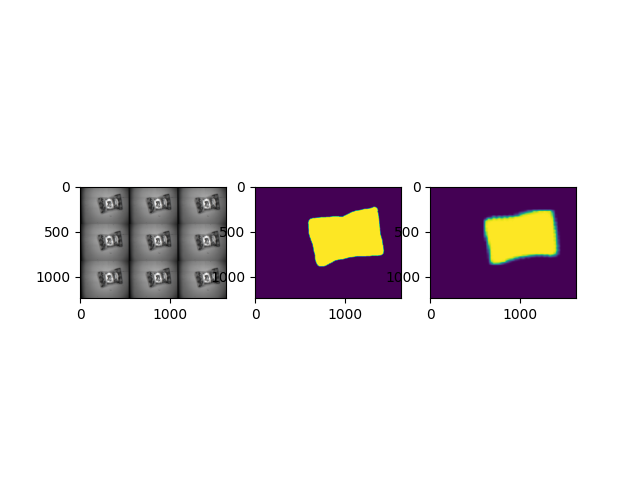

In [23]:
evalResult(4)

In [19]:
type(model)

torchvision.models.detection.mask_rcnn.MaskRCNN

In [13]:
torch.save(model, 'modelCN5.pt')

In [14]:
#model = torch.load('model2.pt')

In [9]:
good[0].shape

(1236, 1626, 3)